# Correlation of class switch decisions among related cells during in vitro culture

# Setup

In [1]:
output_dir = ""
output_suffix = ""
output_format = ".png"
output_format2 = ".pdf"

output_formats = [output_format, output_format2]

In [8]:
import time
import itertools
import copy
import json
import MySQLdb

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

import seaborn as sns

In [9]:
# Plot settings
sns.set(style="darkgrid")

fig_scale = 4

matplotlib.rc('font', size=18)
matplotlib.rc('text', usetex=False)
matplotlib.rc('savefig', dpi=150)

np.set_printoptions(suppress=True, precision=2) # string format

# Isotype to color map
path_to_isotype_to_color_map = "/datastore/rfhorns/resources/immune/isotype_to_color_dict.json"
with open(path_to_isotype_to_color_map, 'rU') as f:
    isotype_to_color = json.load(f)
    
# Isotype to position/uid map
isotype_names = ['Naive', 'IgG3', 'IgG1', 'IgA1', 'IgG2', 'IgG4', 'IgE', 'IgA2']
isotype_to_uid = dict(zip(isotype_names,range(len(isotype_names))))

# Saving figures
def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

def modifyAxesFelix(ax, ticklabels=False):
    ''' Removes top and right axes. Shifts left axis by 5pt '''
    if ticklabels:
        ax.get_xaxis().set_ticks_position('bottom')
        ax.get_yaxis().set_ticks_position('left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('outward',5))
    ax.spines['bottom'].set_position(('outward',5))

# Load genealogical data 

In [10]:
def load_df(d):
    col_names = ["mrca_uid", "mrca_isotype",
                "sib1_uid", "sib1", "isotype_sib1",
                "sib2_uid", "sib2", "isotype_sib2",
                "kinship", "dist1", "dist2",
                "sib1_switch_uid", "sib1_switch_id", "sib1_switch_isotype",
                "sib1_switch_steps", "sib1_switch_dist",
                "sib2_switch_uid", "sib2_switch_id", "sib2_switch_isotype",
                "sib2_switch_steps", "sib2_switch_dist"]
    df = pd.io.parsers.read_table(d+"/sibs.clean.txt", names=col_names, header=None)
    return df

def replace_naive(df):

    naive_isotypes = ["IgM", "IgD"]
    naive_label = "Naive"

    df_naive = df.copy()
    df_naive.mrca_isotype[df.mrca_isotype.isin(naive_isotypes)] = naive_label
    df_naive.isotype_sib1[df.isotype_sib1.isin(naive_isotypes)] = naive_label
    df_naive.isotype_sib2[df.isotype_sib2.isin(naive_isotypes)] = naive_label
    df_naive.sib1_switch_isotype[df.sib1_switch_isotype.isin(naive_isotypes)] = naive_label
    df_naive.sib2_switch_isotype[df.sib2_switch_isotype.isin(naive_isotypes)] = naive_label

    return df_naive

def filter_df(df):
    df_filtered = df.copy()
    df_filtered = df_filtered[df_filtered.mrca_isotype == df_filtered.isotype_sib1]
    df_filtered = df_filtered[(df_filtered.sib1_switch_isotype != df_filtered.isotype_sib1) & (df_filtered.sib2_switch_isotype != df_filtered.isotype_sib1)]
#    df_filtered = df_filtered[np.absolute(df_filtered.dist_to_mrca1 - df_filtered.dist_to_mrca2) < 7]
    return df_filtered

def drop_redundant_cols(df):
    df_pruned = df.copy()
    df_pruned.drop("sib1", axis=1, inplace=True)
    df_pruned.drop("sib2", axis=1, inplace=True)
    df_pruned.drop("sib1_switch_id", axis=1, inplace=True)
    df_pruned.drop("sib2_switch_id", axis=1, inplace=True)
    return df_pruned

def append_clustering(df):
    clustering_num = [int(str(x)[-9]) for x in list(df["mrca_uid"])]
    df["clustering_num"] = clustering_num
    return df

def load_filtered_df(d):
    df = drop_redundant_cols(filter_df(replace_naive(load_df(d))))
    df = append_clustering(df)
    df = df[df["clustering_num"] == 1]
    print "Pairs of related cells:", df.shape[0]
    return df

In [11]:
input_dir = "/local10G/rfhorns/Bcell/classSwitchCulture/ir/figures/data4/"
df_all = load_filtered_df(input_dir)

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.p

Pairs of related cells: 34388


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


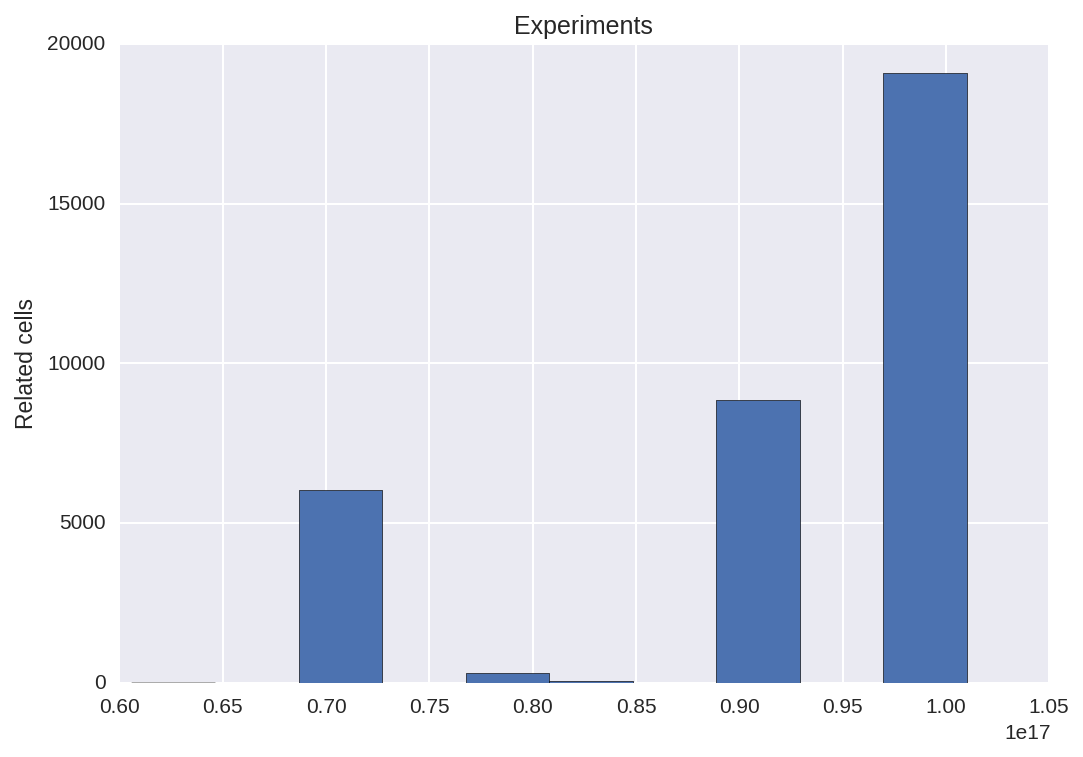

In [12]:
# Number of related cells in each experiment before filtering
plt.hist(np.array(df_all["mrca_uid"]))
plt.title("Experiments")
plt.ylabel("Related cells")

In [13]:
# Split data into experiments
df_IgM = df_all[df_all["mrca_uid"] >= 6e16][df_all["mrca_uid"] <= 7e16]
df_Stim_200_1 = df_all[df_all["mrca_uid"] >= 7e16][df_all["mrca_uid"] <= 8e16]
df_Stim_100_1 = df_all[df_all["mrca_uid"] >= 8e16][df_all["mrca_uid"] <= 9e16]
df_Stim_100_2 = df_all[df_all["mrca_uid"] >= 9e16][df_all["mrca_uid"] <= 10e16]
df_Stim_100_3 = df_all[df_all["mrca_uid"] >= 10e16][df_all["mrca_uid"] <= 11e16]

/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [14]:
print "Number of related cells per experiment"
print df_IgM.shape[0]
print df_Stim_200_1.shape[0]
print df_Stim_100_1.shape[0]
print df_Stim_100_2.shape[0]
print df_Stim_100_3.shape[0]
print

print "Total"
print df_IgM.shape[0] + df_Stim_200_1.shape[0] + df_Stim_100_1.shape[0] + df_Stim_100_2.shape[0] + df_Stim_100_3.shape[0]
# Adds up to all cells in original df -- great!

Number of related cells per experiment
1
6027
404
8873
19083

Total
34388


# Inspect data

In [15]:
df_Stim_200_1

mrca_uid mrca_isotype           sib1_uid isotype_sib1  \
11     70702010100132710        Naive  70702010100057278        Naive   
12     70702010100139457        Naive  70702010100057278        Naive   
13     70702010100132710        Naive  70702010100057278        Naive   
14     70702010100132710        Naive  70702010100057278        Naive   
15     70702010100132710        Naive  70702010100057278        Naive   
16     70702010100153958         IgG1  70702010100139292         IgG1   
17     70702010100083015         IgG2  70702010100077442         IgG2   
18     70702010100083015         IgG2  70702010100077442         IgG2   
19     70702010100139457        Naive  70702010100160837        Naive   
20     70702010100132710        Naive  70702010100160837        Naive   
21     70702010100132710        Naive  70702010100160837        Naive   
22     70702010100132710        Naive  70702010100160837        Naive   
23     70702010100139457        Naive  70702010100139457        Naive   
24     70702010100139457        Naive  70702010100139457        Naive   
25     70702010100139457        Naive  70702010100139457        Naive   
26     70702010100083015         IgG2  70702010100112039         IgG2   
27     70702010100132710        Naive  70702010100115075        Naive   
28     70702010100132710        Naive  70702010100115075        Naive   
29     70702010100132710        Naive  70702010100132710        Naive   
11238  70702010100170957         IgG1  70702010100169774         IgG1   
11239  70702010100170957         IgG1  70702010100169774         IgG1   
11240  70702010100170957         IgG1  70702010100169774         IgG1   
11241  70702010100170957         IgG1  70702010100169774         IgG1   
11242  70702010100170957         IgG1  70702010100169774         IgG1   
11243  70702010100170957         IgG1  70702010100169774         IgG1   
11244  70702010100170957         IgG1  70702010100169774         IgG1   
11245  70702010100170957         IgG1  70702010100169774         IgG1   
11246  70702010100096559         IgG1  70702010100169774         IgG1   
11247  70702010100170957         IgG1  70702010100169774         IgG1   
11248  70702010100170957         IgG1  70702010100169774         IgG1   
...                  ...          ...                ...          ...   
39013  70702010100134560         IgG1  70702010100134560         IgG1   
39015  70702010100130217        Naive  70702010100167658        Naive   
39016  70702010100009616        Naive  70702010100167658        Naive   
39018  70702010100130217        Naive  70702010100026428        Naive   
39092  70702010100047752         IgA1  70702010100047752         IgA1   
39093  70702010100123995        Naive  70702010100123995        Naive   
39305  70702010100006342        Naive  70702010100044189        Naive   
39306  70702010100096112        Naive  70702010100044189        Naive   
39307  70702010100044189        Naive  70702010100044189        Naive   
39308  70702010100096112        Naive  70702010100006342        Naive   
39309  70702010100006342        Naive  70702010100006342        Naive   
39310  70702010100096112        Naive  70702010100096112        Naive   
39357  70702010100135616        Naive  70702010100135616        Naive   
39358  70702010100119953        Naive  70702010100135616        Naive   
39359  70702010100119953        Naive  70702010100138754        Naive   
39360  70702010100036933         IgA1  70702010100125636         IgA1   
39361  70702010100060123         IgA1  70702010100125636         IgA1   
39362  70702010100153638         IgA1  70702010100125636         IgA1   
39363  70702010100036933         IgA1  70702010100036933         IgA1   
39364  70702010100036933         IgA1  70702010100036933         IgA1   
39365  70702010100153638         IgA1  70702010100060123         IgA1   
39424  70702010100013117         IgG1  70702010100011077         IgG1   
39425  70702010100137314         IgG1  70702010100011077         IgG1   
3

# Filter for pairs with inherited mutations

In [16]:
# Load mutations from SQL
def load_muts_df():

    db = MySQLdb.connect(host="scigc-vm-47", # your host, usually localhost
                         user="rfhorns", # your username
                         passwd="immuno", # your password
                         db="Bcell_classSwitchCulture1") # name of the data base
    
    query = """
        SELECT s.uid, s.mut_germline_positions, s.mut_germline_before, s.mut_germline_after
        FROM sequences s, clusterings c, lineages l
        WHERE s.lineage_uid = l.uid
        AND l.num_unique_seqs > 2
        AND s.clustering_uid = c.uid
        AND c.clustering_CDR3_similarity_cutoff < 0.96
        AND c.clustering_CDR3_similarity_cutoff > 0.94
        """

    print "Loading data..."
    start_time = time.time()

    df = pd.io.sql.read_sql(query, db)

    if df.shape[0] == 0:
        print "Error: no rows loaded"

    elapsed_time = time.time() - start_time
    print "Wall clock time", elapsed_time
    print
    
    return df

In [17]:
df_muts = load_muts_df()
df_muts.set_index("uid", inplace=True)
print df_muts.shape

Loading data...
Wall clock time 9.3681640625

(616505, 3)


In [18]:
def append_mut_germline_data(df, df_muts):
    """ Get germline mutations of each sequence """
    
    names = ["mrca", "sib1", "sib2", "sib1_switch", "sib2_switch"]
    
    for name in names:
        x = df_muts.loc[df[name + "_uid"]]
        x.columns = [name + "_" + s for s in list(x.columns)]
        x["index"] = df.index
        x.set_index("index", inplace=True, drop=True)
        df = pd.concat([df, x], axis=1, join="inner")
    
    return df

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def mutStrToSet(s):
    if isfloat(s):
        return set([])
    else:
        return set(s.split(","))

def call_sequential_muts(df):
    """ Add flag indicating whether each descendant inherits all mutations from ancestor. """
    
    has_sequential_muts = []
    
    for i, row in df.iterrows():
        
        mrca = mutStrToSet(row["mrca_mut_germline_positions"])
        sib1 = mutStrToSet(row["sib1_mut_germline_positions"])
        sib2 = mutStrToSet(row["sib2_mut_germline_positions"])
        sib1_switch = mutStrToSet(row["sib1_switch_mut_germline_positions"])
        sib2_switch = mutStrToSet(row["sib2_switch_mut_germline_positions"])
        
        if mrca <= sib1 and mrca <= sib2 and sib1 <= sib1_switch and sib2 <= sib2_switch:
            s = 1
        else:
            s = 0
            
        has_sequential_muts.append(s)
        
    df["has_sequential_muts"] = has_sequential_muts

    return df

In [19]:
df_all = append_mut_germline_data(df_all, df_muts)
df_all = call_sequential_muts(df_all)
df_all = df_all[df_all["has_sequential_muts"] == 1]
print df_all.shape

(21343, 34)


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
df_all.head()

mrca_uid mrca_isotype            sib1_uid isotype_sib1  \
1  101002010100065478        Naive  101002010100103482        Naive   
2  101002010100066969        Naive  101002010100103482        Naive   
3  101002010100066969        Naive  101002010100065478        Naive   
6   90902010100142549        Naive   90902010100058287        Naive   
9   90902010100008859         IgG1   90902010100051651         IgG1   

             sib2_uid isotype_sib2  kinship  dist1  dist2     sib1_switch_uid  \
1  101002010100065478        Naive        1      1      0  101002010100091230   
2  101002010100066969        Naive        2      2      0  101002010100091230   
3  101002010100066969        Naive        1      1      0  101002010100101598   
6   90902010100142549        Naive        1      1      0   90902010100001324   
9   90902010100008859         IgG1        1      2      0   90902010100124152   

          ...                                sib2_mut_germline_positions  \
1         ...          V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
2         ...          V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
3         ...          V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
6         ...          V27,V31,V57,V67,V85,V87,V89,V90,V92,V96,V97,V9...   
9         ...          V28,V31,V78,V111,V124,V129,V174,V179,V182,V185...   

                            sib2_mut_germline_before  \
1  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
2  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
3  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
6  T,C,G,A,C,C,G,C,C,T,G,G,A,A,T,C,A,A,A,G,C,A,A,...   
9                  A,C,G,C,C,A,T,A,A,G,A,C,A,C,G,C,T   

                             sib2_mut_germline_after  \
1  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...   
2  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...   
3  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...   
6  G,G,A,T,G,G,C,A,G,A,C,C,G,C,G,T,G,G,C,A,T,T,T,...   
9                  G,G,A,T,T,C,A,T,T,A,T,T,G,T,A,G,G   

                  sib1_switch_mut_germline_positions  \
1  V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
2  V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
3  V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
6  V27,V31,V57,V67,V85,V87,V89,V90,V92,V96,V97,V9...   
9  V28,V31,V57,V78,V111,V124,V129,V174,V179,V182,...   

                     sib1_switch_mut_germline_before  \
1  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
2  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
3  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
6  T,C,G,A,C,C,G,C,C,T,G,G,A,A,A,T,C,A,A,A,G,C,A,...   
9  A,C,G,G,C,C,A,T,A,A,G,A,C,A,C,C,T,C,G,A,C,A,T,T,G   

                      sib1_switch_mut_germline_after  \
1  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...   
2  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...   
3  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...   
6  G,G,A,T,G,G,C,A,G,A,C,C,G,C,C,G,T,G,G,C,A,T,T,...   
9  G,G,A,A,T,T,C,A,T,T,A,T,T,G,A,T,G,A,A,C,A,G,G,G,T   

                  sib2_switch_mut_germline_positions  \
1  V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
2  V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
3  V66,V68,V83,V84,V85,V89,V92,V93,V148,V150,V157...   
6  V27,V31,V57,V67,V85,V87,V89,V90,V92,V96,V97,V9...   
9  V28,V31,V57,V78,V111,V124,V129,V174,V179,V182,...   

                     sib2_switch_mut_germline_before  \
1  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
2  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
3  T,C,C,C,T,G,G,C,G,T,T,A,A,A,A,C,G,C,A,A,T,G,G,...   
6  T,C,G,A,C,C,G,C,C,T,G,G,A,A,A,T,C,A,A,A,G,C,A,...   
9  A,C,G,G,C,C,A,T,A,A,G,A,C,A,C,C,T,C,G,A,C,A,T,T,G   

                      sib2_switch_mut_germline_after has_sequential_muts  
1  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...                   1  
2  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...                   1  
3  C,T,G,T,C,C,C,T,A,G,C,G,T,G,C,T,C,T,T,G,C,T,A,...      

In [21]:
# Show example of sibling pair with sequential mutations
df_all[df_all["has_sequential_muts"] == 1].iloc[2]

mrca_uid                                                             101002010100066969
mrca_isotype                                                                      Naive
sib1_uid                                                             101002010100065478
isotype_sib1                                                                      Naive
sib2_uid                                                             101002010100066969
isotype_sib2                                                                      Naive
kinship                                                                               1
dist1                                                                                 1
dist2                                                                                 0
sib1_switch_uid                                                      101002010100101598
sib1_switch_isotype                                                                IgG1
sib1_switch_steps               

# Calculate mutational distances 

In [22]:
def calc_mut_dists(df):
    df["mean_sib_dist"] = df.dist1 + df.dist2 / 2
    df["max_sib_dist"] = np.array([max(x1, x2) for x1, x2 in zip(list(df.dist1), list(df.dist2))])
    return df

In [23]:
df_all = calc_mut_dists(df_all)

# Split into distinct experiments

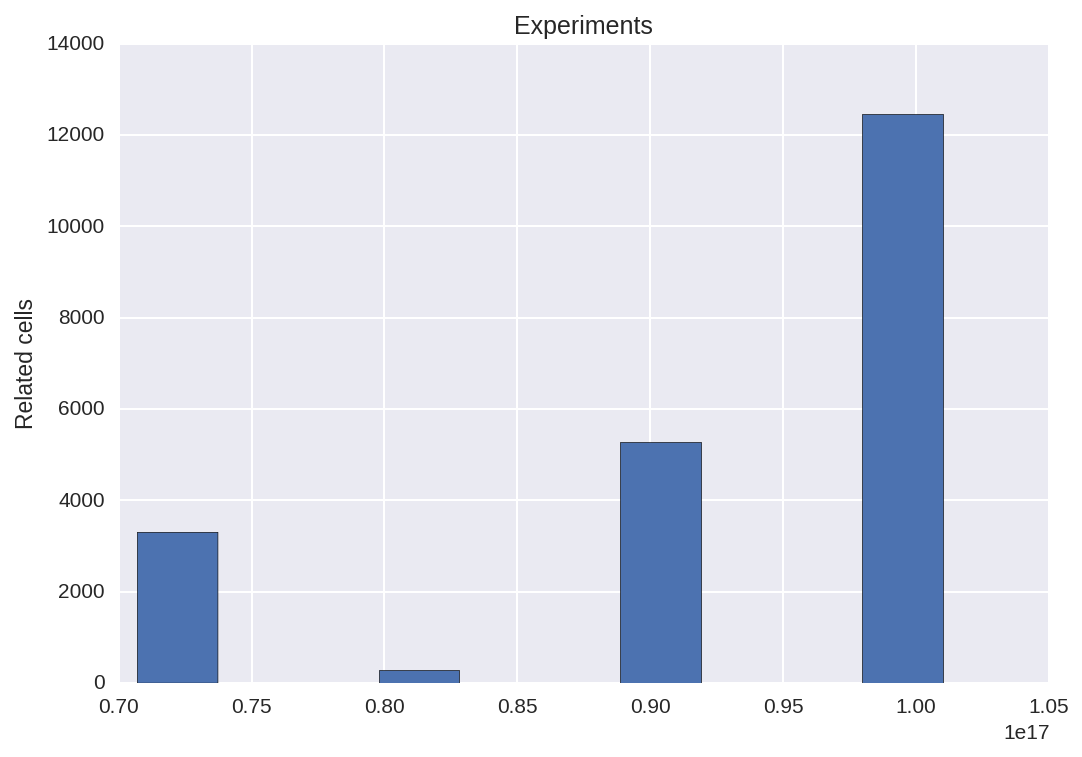

In [24]:
# Number of related cells in each experiment after filtering for sequential muts
plt.hist(np.array(df_all["mrca_uid"]))
plt.title("Experiments")
plt.ylabel("Related cells")

In [25]:
# Split data into experiments
df_IgM = df_all[df_all["mrca_uid"] >= 6e16][df_all["mrca_uid"] <= 7e16]
df_Stim_200_1 = df_all[df_all["mrca_uid"] >= 7e16][df_all["mrca_uid"] <= 8e16]
df_Stim_100_1 = df_all[df_all["mrca_uid"] >= 8e16][df_all["mrca_uid"] <= 9e16]
df_Stim_100_2 = df_all[df_all["mrca_uid"] >= 9e16][df_all["mrca_uid"] <= 10e16]
df_Stim_100_3 = df_all[df_all["mrca_uid"] >= 10e16][df_all["mrca_uid"] <= 11e16]

In [26]:
print "Number of related cells per experiment"
print df_IgM.shape[0]
print df_Stim_200_1.shape[0]
print df_Stim_100_1.shape[0]
print df_Stim_100_2.shape[0]
print df_Stim_100_3.shape[0]
print

print "Total"
print df_IgM.shape[0] + df_Stim_200_1.shape[0] + df_Stim_100_1.shape[0] + df_Stim_100_2.shape[0] + df_Stim_100_3.shape[0]
# Adds up to all cells in original df after filtering -- great!

Number of related cells per experiment
0
3302
287
5283
12471

Total
21343


In [27]:
dfs = (df_Stim_200_1, df_Stim_100_2, df_Stim_100_3) # bind together for convenience
names = ["Replicate 1", "Replicate 2", "Replicate 3"]

# Basic summary statistics

In [28]:
# Number of Naive pairs
s = 0
for df in dfs:
    x = df[df["isotype_sib1"] == "Naive"].shape[0]
    s += x
    print x

print
    
print "Total"
print s


554
584
737

Total
1875


# Plot basic descriptions of datasets

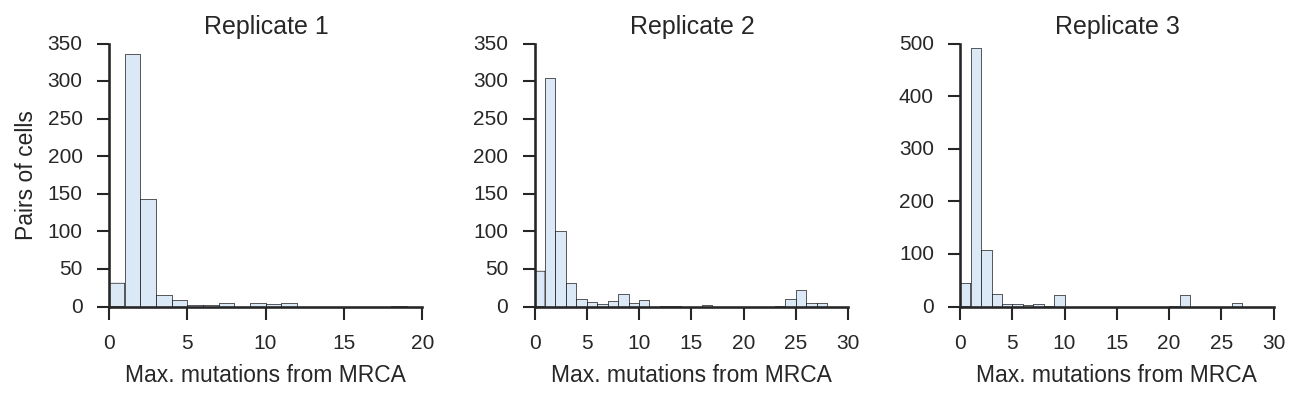

In [36]:
# Distribution of max mutations to MRCA
sns.set_style("ticks")
sns.set_palette("Blues")
fig, axes = plt.subplots(1, len(dfs), figsize=(3 * len(dfs),3))
for ax, df, title in zip(axes, dfs, names):
    df_subset = df[df["isotype_sib1"] == "Naive"]
    x = list(df_subset.max_sib_dist)
    ax.hist(x, bins=max(x))
    # ax.set_yscale("log")
    # ax.set_ylim(bottom=0.5)
    # ax.set_aspect('equal')
    ax.set_xlabel("Max. mutations from MRCA")
    ax.set_title(title)
axes[0].set_ylabel("Pairs of cells")
sns.despine()
plt.tight_layout()

if savefig: save_figure(fig, "hist_maxMutsMRCA_Stim_culture160105", output_dir, output_suffix, output_formats, savefig_args)

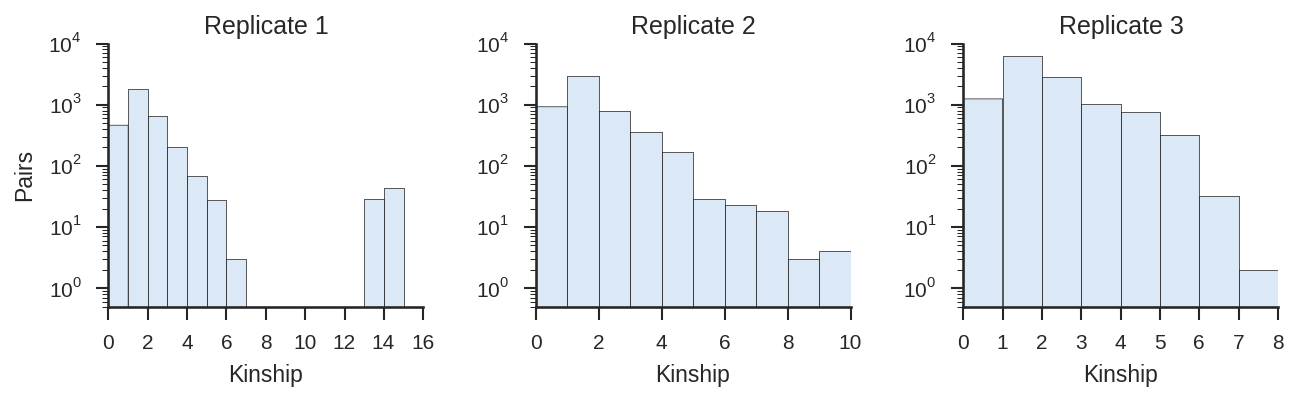

In [110]:
# Distribution of kinship values
sns.set_style("ticks")
sns.set_palette("Blues")
fig, axes = plt.subplots(1, len(dfs), figsize=(3 * len(dfs),3))
for ax, df, title in zip(axes, dfs, names):
    x = list(df.kinship)
    ax.hist(x, bins=max(x))
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.5)
    ax.set_aspect('equal')
    ax.set_xlabel("Kinship")
    ax.set_title(title)
axes[0].set_ylabel("Pairs")
sns.despine()
plt.tight_layout()

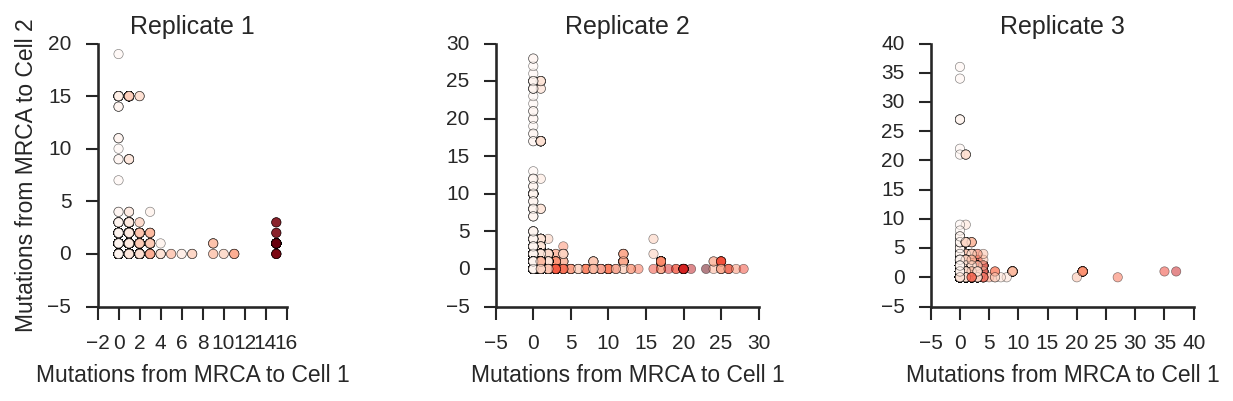

In [111]:
# Distribution of mutations from MRCA to Cell 1 and 2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, len(dfs), figsize=(3 * len(dfs),3))
for ax, df, title in zip(axes, dfs, names):
    x = list(df.dist1)
    y = list(df.dist2)
    c = list(df.kinship)
    ax.scatter(x, y, c=c, alpha=0.5, cmap=cmap)
    ax.set_aspect('equal')
    ax.set_xlabel("Mutations from MRCA to Cell 1")
    ax.set_title(title)
axes[0].set_ylabel("Mutations from MRCA to Cell 2")
sns.despine()
plt.tight_layout()

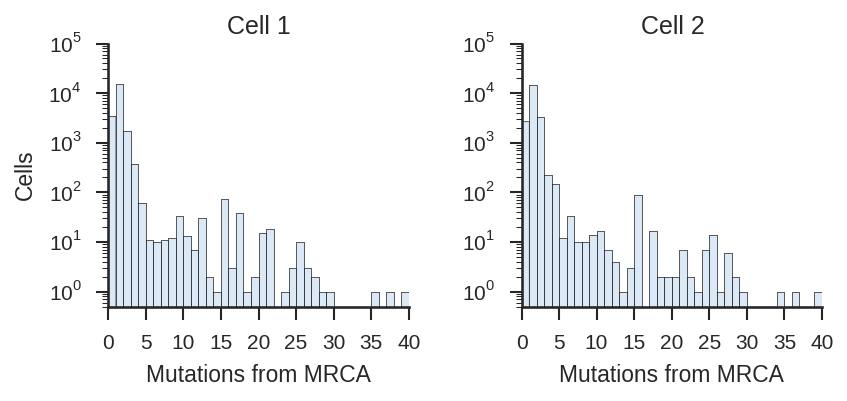

In [23]:
# not updated for 160105 dataset

# Distributions of distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
ax = axes[0]
x = list(df_V1.dist1)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 1")
ax.set_xlabel("Mutations from MRCA")
ax.set_ylabel("Cells")
ax = axes[1]
x = list(df_V1.dist2)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 2")
ax.set_xlabel("Mutations from MRCA")
sns.despine()
plt.tight_layout()

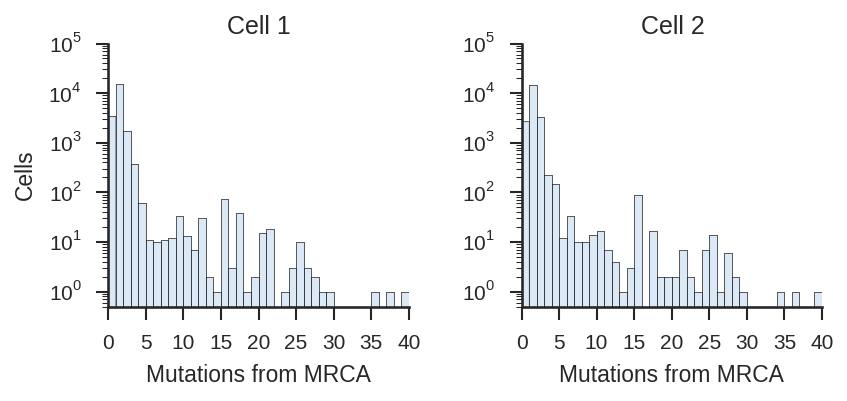

In [24]:
# not updated for 160105 dataset

# Distributions of distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, 2, figsize=(6,3))
ax = axes[0]
x = list(df_V3.dist1)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 1")
ax.set_xlabel("Mutations from MRCA")
ax.set_ylabel("Cells")
ax = axes[1]
x = list(df_V3.dist2)
ax.hist(x, bins=max(x))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cell 2")
ax.set_xlabel("Mutations from MRCA")
sns.despine()
plt.tight_layout()

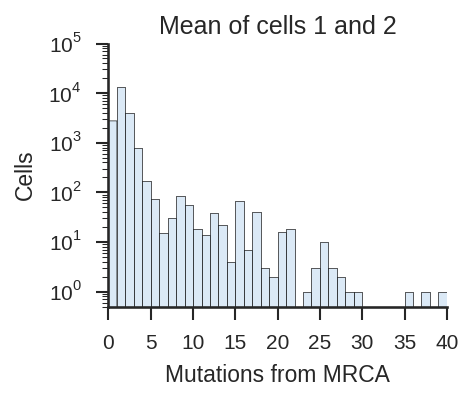

In [25]:
# not updated for 160105 dataset

# Distribution of mean distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
x = list(df_V1.mean_sib_dist)
ax.hist(x, bins=int(max(x)))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Mean of cells 1 and 2")
ax.set_xlabel("Mutations from MRCA")
ax.set_ylabel("Cells")
ax.set_aspect('equal')
sns.despine()
plt.tight_layout()

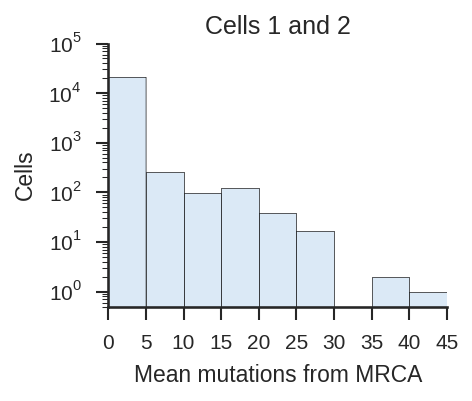

In [26]:
# not updated for 160105 dataset

# Distributions of mean distance to sib1 and sib2 with bigger bins
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
x = list(df_V1.mean_sib_dist)
bins = np.arange(0, 50, 5)
ax.hist(x, bins=bins)
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cells 1 and 2")
ax.set_xlabel("Mean mutations from MRCA")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()

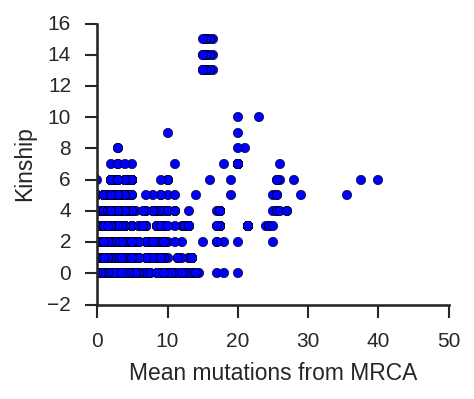

In [27]:
# not updated for 160105 dataset

# Kinship versus mean mutations from MRCA
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
ax.scatter(list(df_V1.mean_sib_dist), list(df_V1.kinship))
ax.set_xlim(left=0)
ax.set_title("")
ax.set_xlabel("Mean mutations from MRCA")
ax.set_ylabel("Kinship")
sns.despine()
plt.tight_layout()

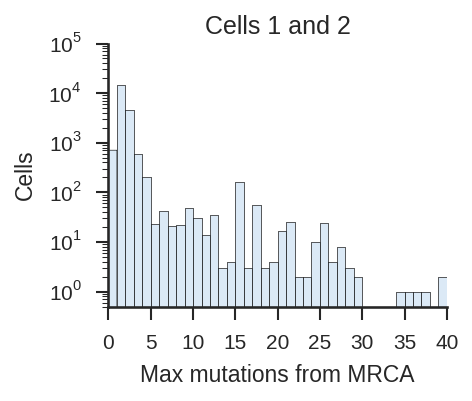

In [28]:
# not updated for 160105 dataset

# Distribution of max distance to sib1 and sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
x = list(df_V1.max_sib_dist)
ax.hist(x, bins=int(max(x)))
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cells 1 and 2")
ax.set_xlabel("Max mutations from MRCA")
ax.set_ylabel("Cells")
ax.set_aspect('equal')
sns.despine()
plt.tight_layout()

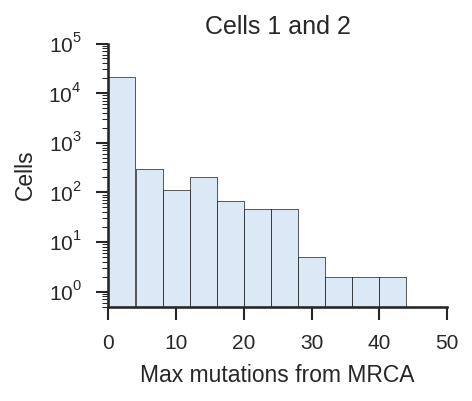

In [29]:
# not updated for 160105 dataset

# Distributions of max distance to sib1 and sib2 with bigger bins
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
x = list(df_V1.max_sib_dist)
bins = np.arange(0, 50, 4)
ax.hist(x, bins=bins)
ax.set_yscale("log")
ax.set_ylim(bottom=0.5)
ax.set_title("Cells 1 and 2")
ax.set_xlabel("Max mutations from MRCA")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()

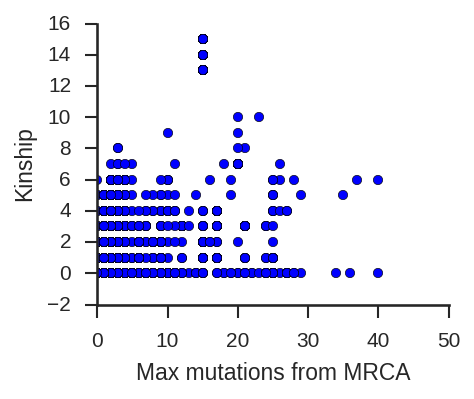

In [30]:
# not updated for 160105 dataset

# Kinship versus max mutations from MRCA
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
ax.scatter(list(df_V1.max_sib_dist), list(df_V1.kinship))
ax.set_xlim(left=0)
ax.set_title("")
ax.set_xlabel("Max mutations from MRCA")
ax.set_ylabel("Kinship")
sns.despine()
plt.tight_layout()

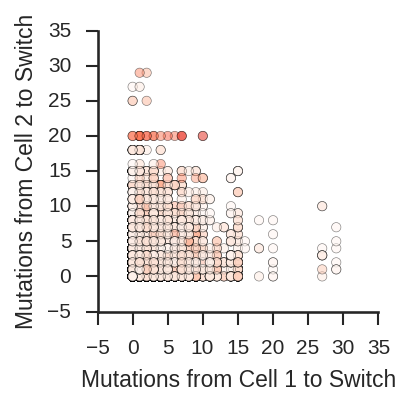

In [31]:
# not updated for 160105 dataset

# Distance to switches sib1 vs sib2
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.scatter(list(df_V1.sib1_switch_dist), list(df_V1.sib2_switch_dist), c=list(df_V1.kinship), alpha=0.5, cmap=cmap)
ax.set_aspect('equal')
ax.set_xlabel("Mutations from Cell 1 to Switch")
ax.set_ylabel("Mutations from Cell 2 to Switch")
sns.despine()
plt.tight_layout()

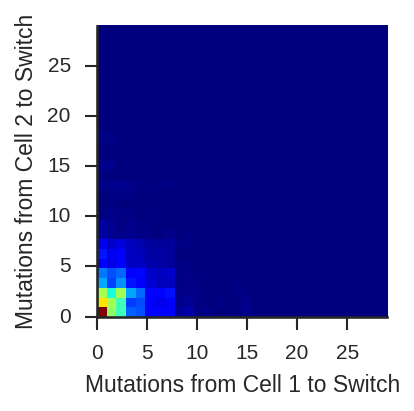

In [32]:
# Distance to switches sib1 vs sib2 as heatmap
sns.set_style("ticks")
cmap = plt.get_cmap("jet")
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.hist2d(list(df_V1.sib1_switch_dist), list(df_V1.sib2_switch_dist), bins=30, cmap=cmap)
ax.set_aspect('equal')
ax.set_xlabel("Mutations from Cell 1 to Switch")
ax.set_ylabel("Mutations from Cell 2 to Switch")
sns.despine()
plt.tight_layout()

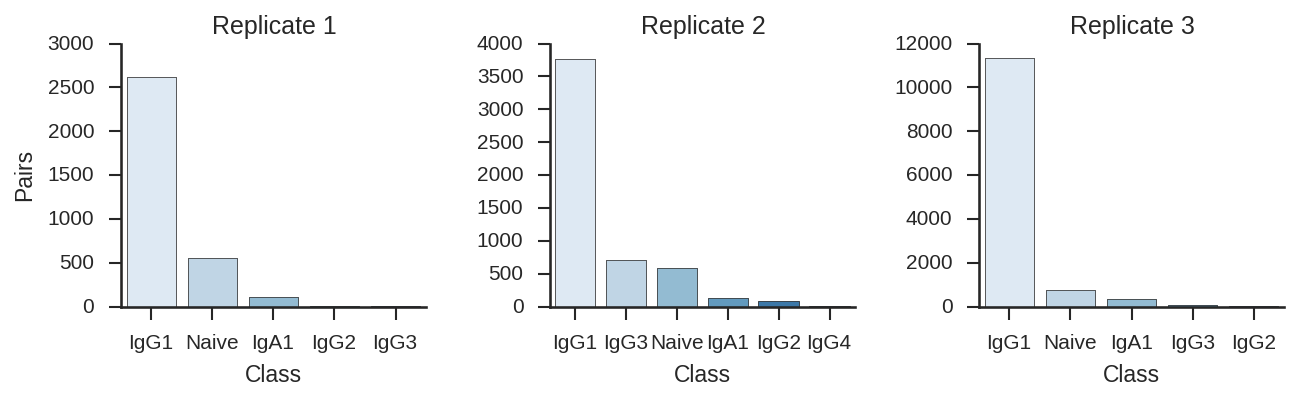

In [112]:
# Distribution of origin isotypes
sns.set_style("ticks")
cmap = plt.get_cmap("Reds")
fig, axes = plt.subplots(1, len(dfs), figsize=(3 * len(dfs),3))
for ax, df, title in zip(axes, dfs, names):
    x = df.mrca_isotype.value_counts(normalize=False)
    sns.barplot(ax=ax, y=x, x=x.index)
    # ax.set_aspect('equal')
    ax.set_xlabel("Class")
    ax.set_ylabel("")
    ax.set_title(title)
axes[0].set_ylabel("Pairs")
sns.despine()
plt.tight_layout()

# Bin cells by mutational distance from MRCA

In [29]:
def bin_by_mut_dist(df, bins):
    df["mean_sib_dist_bin"] = np.digitize(df.mean_sib_dist, bins)
    df["max_sib_dist_bin"] = np.digitize(df.max_sib_dist, bins)
    return df

In [30]:
bins = np.arange(0, 50, 2)
for df in dfs:
    df = bin_by_mut_dist(df, bins)

# df_V1 = bin_by_mut_dist(df_V1, bins)
# df_V3 = bin_by_mut_dist(df_V3, bins)

# Shuffle switch isotypes for comparison

In [31]:
def shuffle(df):
    
    df_shuffled = df.copy()
    
    for isotype in df["mrca_isotype"].unique():
        
        isotype_shuffled = np.random.permutation(np.array(df[df.mrca_isotype == isotype].sib2_switch_isotype.tolist())).tolist()
        df_shuffled.loc[df[df.mrca_isotype == isotype].index,"sib2_switch_isotype"] = isotype_shuffled

    return df_shuffled

In [32]:
dfs_shuffled = []
for df in dfs:
    dfs_shuffled.append(shuffle(df))

# Plot conditional probability of switch fate given Cell 2 fate

In [38]:
def plot_cond_probs_by_bins(df, bin_by="max_sib_dist_bin", vmax=len(bins)):
    """ Plot all conditional probabilities """
    
    isotypes_to_skip = ["IgE", "IgG4", "IgG3"]

    isotype_to_row_num = {"IgG1": 0, "IgA1": 1, "IgG2": 2, "IgA2": 3}
    isotype_to_col_num = {"Naive": 0, "IgG1": 1, "IgA1": 2, "IgG2": 3}
    
    cmap = matplotlib.cm.coolwarm_r
    vmin = 1
    vmax = vmax
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    
    sns.set_style("darkgrid")

    fig, axes = plt.subplots(len(isotype_to_row_num.keys()), len(isotype_to_col_num.keys()), figsize=(8, 8), sharex=True, sharey=True)

    # Hide all axes by default
    for a1 in axes:
        for a2 in a1:
            a2.axis('off')

    for isotype, group in df.groupby('mrca_isotype'):

        if isotype in isotypes_to_skip: continue

        col = isotype_to_col_num[isotype]

        for sib1_switch_isotype, group2 in group.groupby('sib1_switch_isotype'):

            if sib1_switch_isotype in isotypes_to_skip: continue

            row = isotype_to_row_num[sib1_switch_isotype]
            ax = axes[row,col]

            row_label = "P(Relative 2 to X | \n Relative 1 to " + sib1_switch_isotype + ")"

            for myBin, group3 in group2.groupby(bin_by):
                
                if myBin > vmax: continue

                my_probs = group3['sib2_switch_isotype'].value_counts(normalize=True)

                x = [isotype_to_uid[i] for i in my_probs.index]
                y = my_probs
                color = [myBin] * len(x)

                ax.scatter(x, y, c=color, cmap=cmap, vmin=vmin, vmax=vmax)

            ax.axis('on')

            ax.set_xlim([0, len(isotype_names)])
            ax.set_ylim([-0.1, 1.1])

            ax.tick_params(axis='x', which='both', top='off')
            ax.tick_params(axis='y', which='both', right='off')

            if col == 0: ax.set_ylabel(row_label)

            if row == len(isotype_to_row_num.keys()) - 1:
                ax.set_xticks(range(1, len(isotype_names)), minor=True)
                ax.set_xticklabels(isotype_names[1:], rotation=90, minor=True)
                ax.set_xticklabels([], minor=False)
            else:
                ax.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
                pass

            if row == col:
                ax.set_title("Relatives were " + isotype.replace("Naive", "IgM/IgD"), y=1.1)

            # Label showing number of pairs
            N_string = "N = " + str(group2.shape[0])
            ax.text(0.5, 1.1, N_string, fontsize=12, zorder=10)
        
    plt.tight_layout(pad=0.01, h_pad=0) # must be called before colorbar
    
    # colorbar
    ax = axes[1,3]
    
    a = np.array([[vmin,vmax]])
    img = ax.imshow(a, cmap=cmap, norm=norm)
    ax.axis('on')
    ax.set_visible(False)
    
    cax = plt.axes([0.8, 0.55, 0.05, 0.2])
    cb = plt.colorbar(img, cax=cax)
    cb.ax.invert_yaxis()
    from matplotlib import ticker
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.set_label("Kinship")
    
    return fig, axes

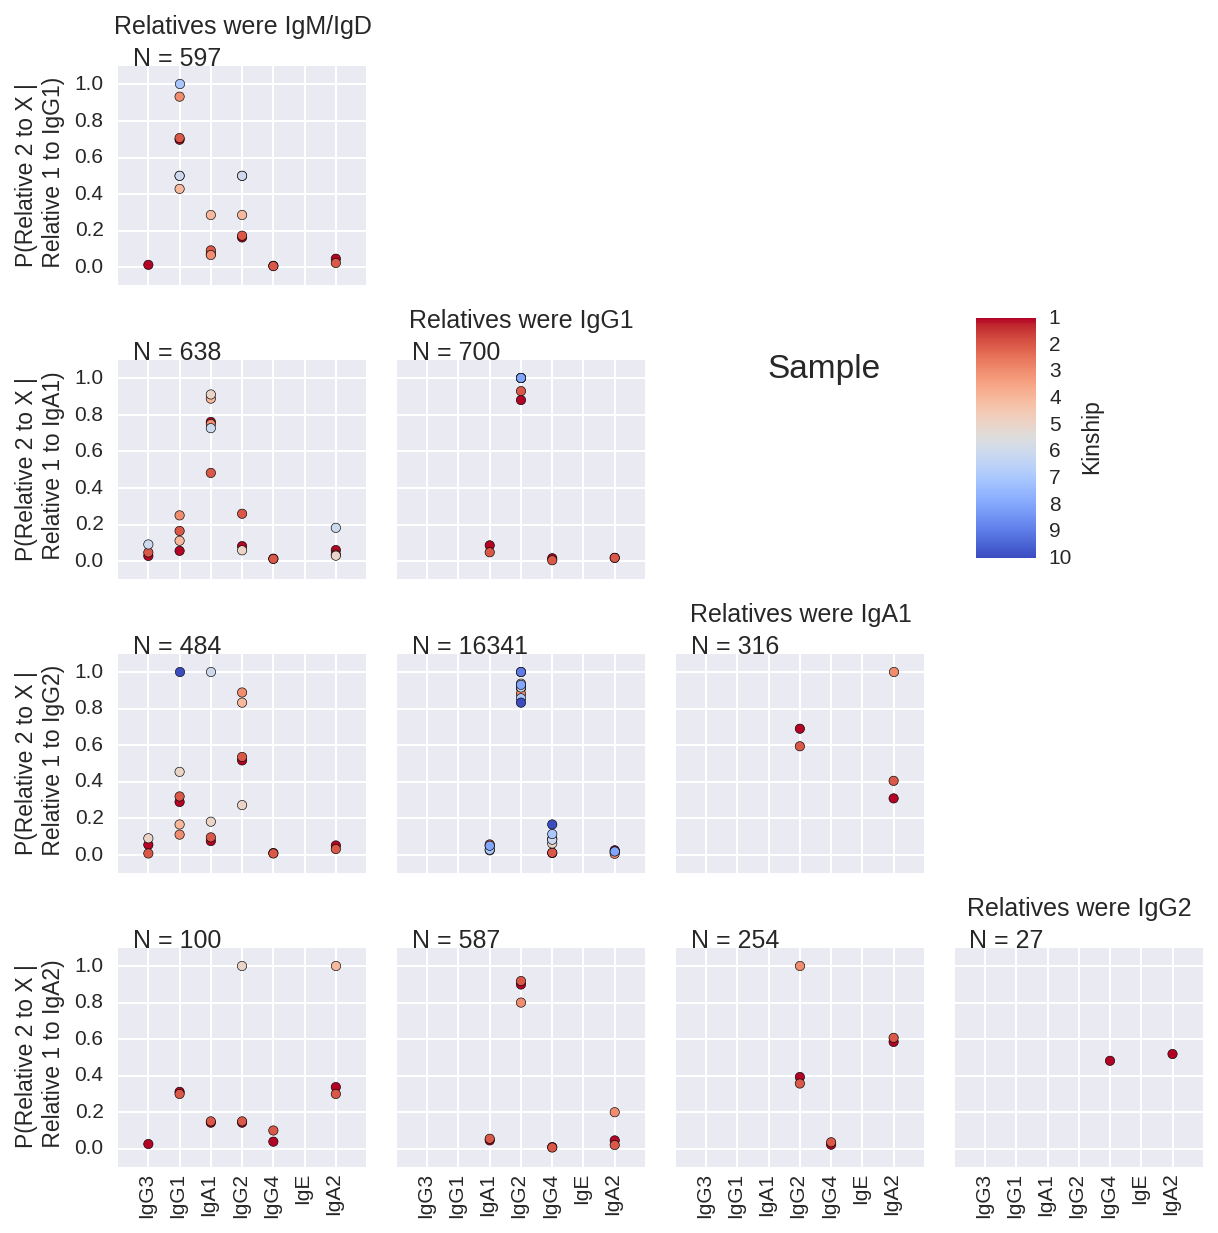

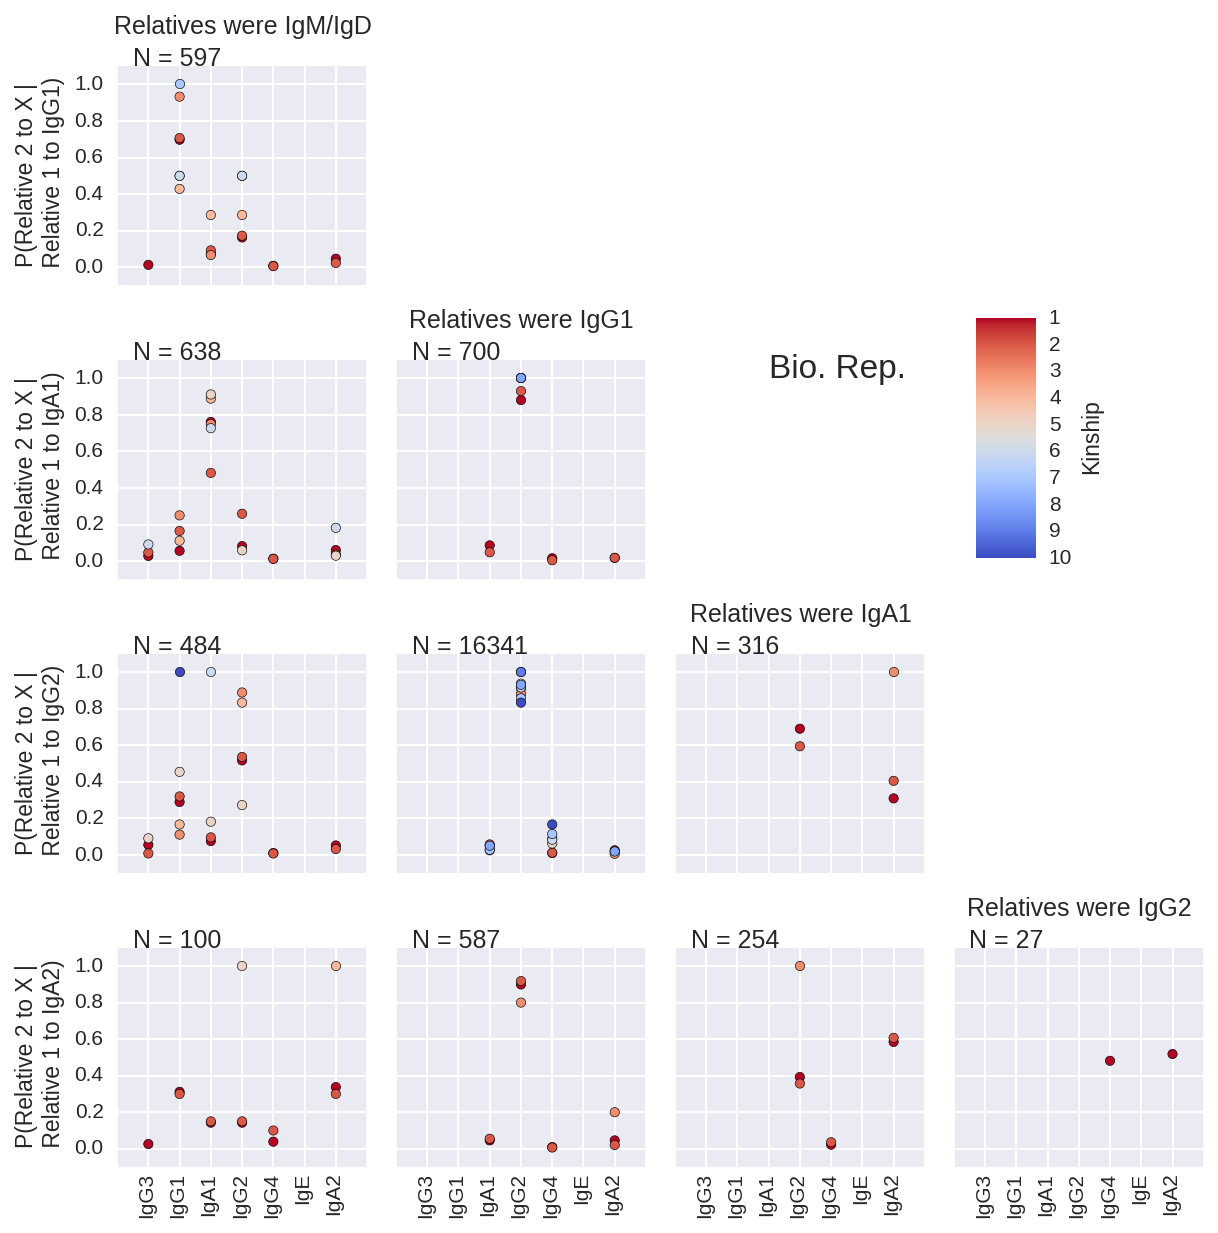

In [39]:
# Bin by max mutational distance
fig, axes = plot_cond_probs_by_bins(df_V1, "max_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Sample", size=16)
# if savefig: save_figure(fig, "sib_conditional_probabilities_V1", output_dir, output_suffix, output_formats, savefig_args)

fig, axes = plot_cond_probs_by_bins(df_V3, "max_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Bio. Rep.", size=16)
# if savefig: save_figure(fig, "sib_conditional_probabilities_V1", output_dir, output_suffix, output_formats, savefig_args)

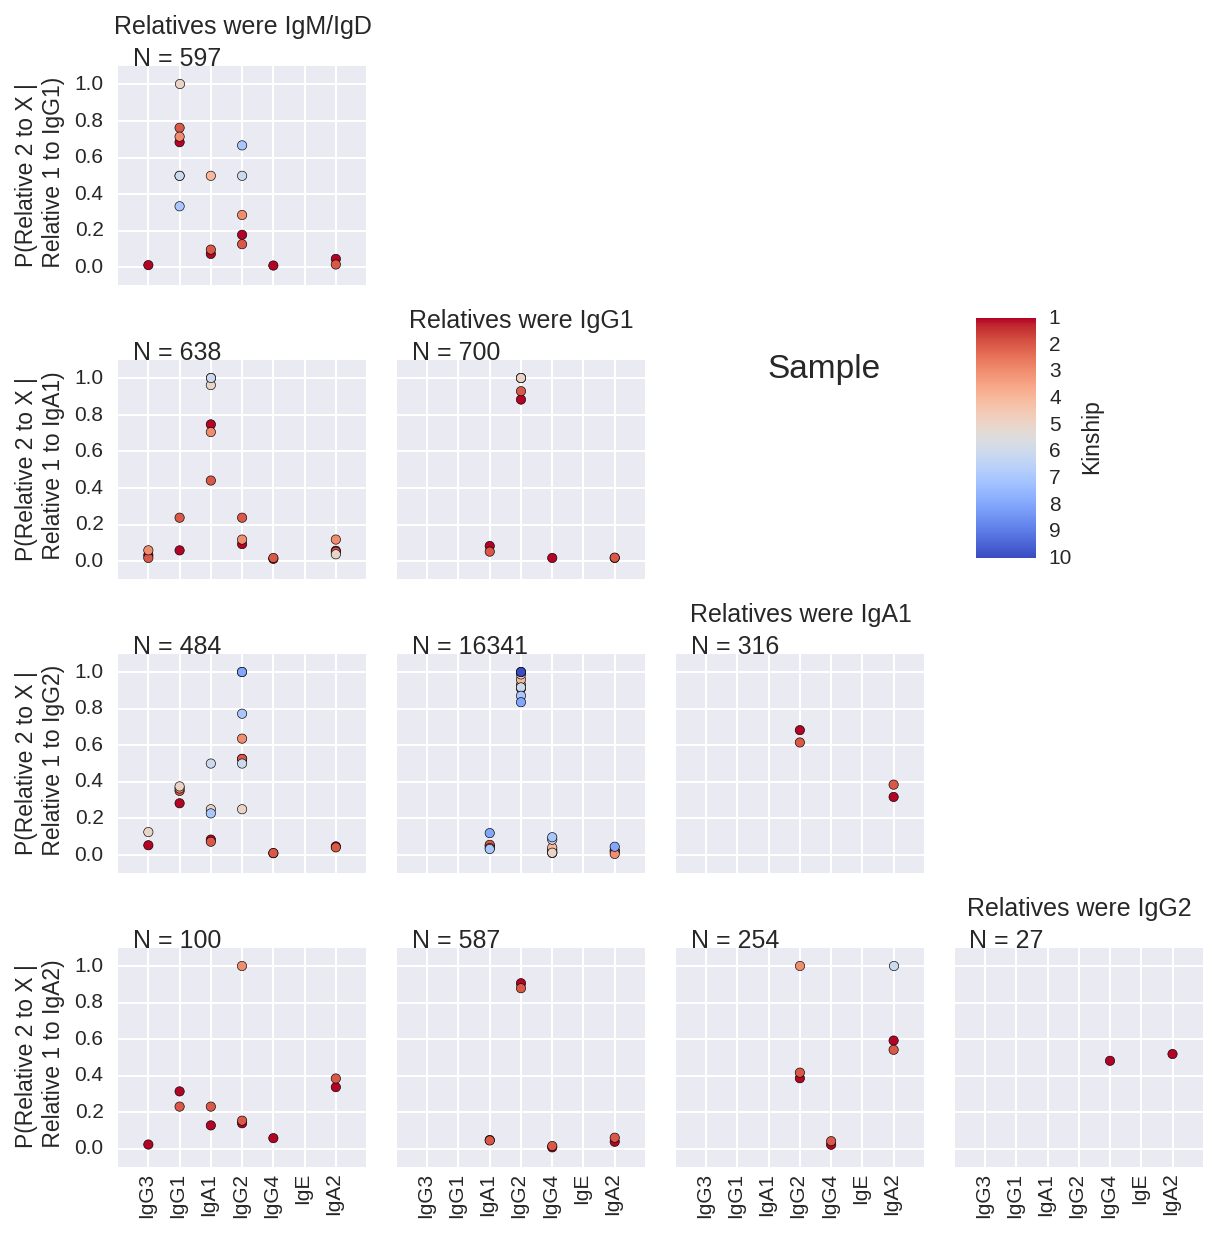

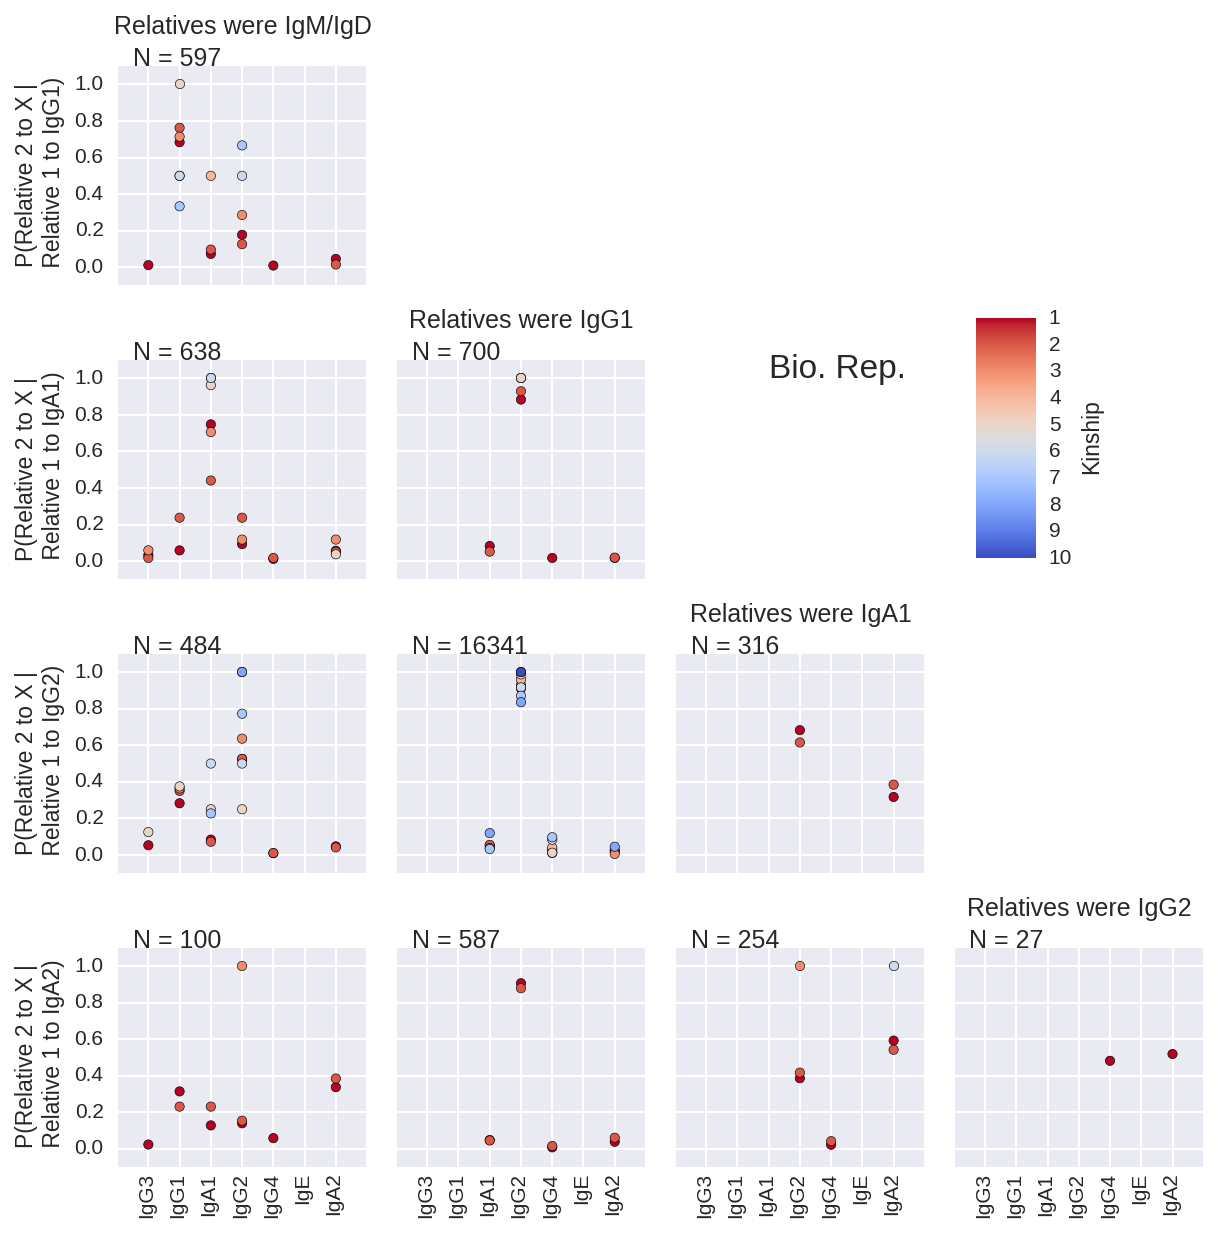

In [40]:
# Bin by mean mutational distance
fig, axes = plot_cond_probs_by_bins(df_V1, "mean_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Sample", size=16)
# if savefig: save_figure(fig, "sib_conditional_probabilities_V1", output_dir, output_suffix, output_formats, savefig_args)

fig, axes = plot_cond_probs_by_bins(df_V3, "mean_sib_dist_bin", vmax=10)
axes[1,2].text(3, 1, "Bio. Rep.", size=16)
# if savefig: save_figure(fig, "sib_conditional_probabilities_V1", output_dir, output_suffix, output_formats, savefig_args)

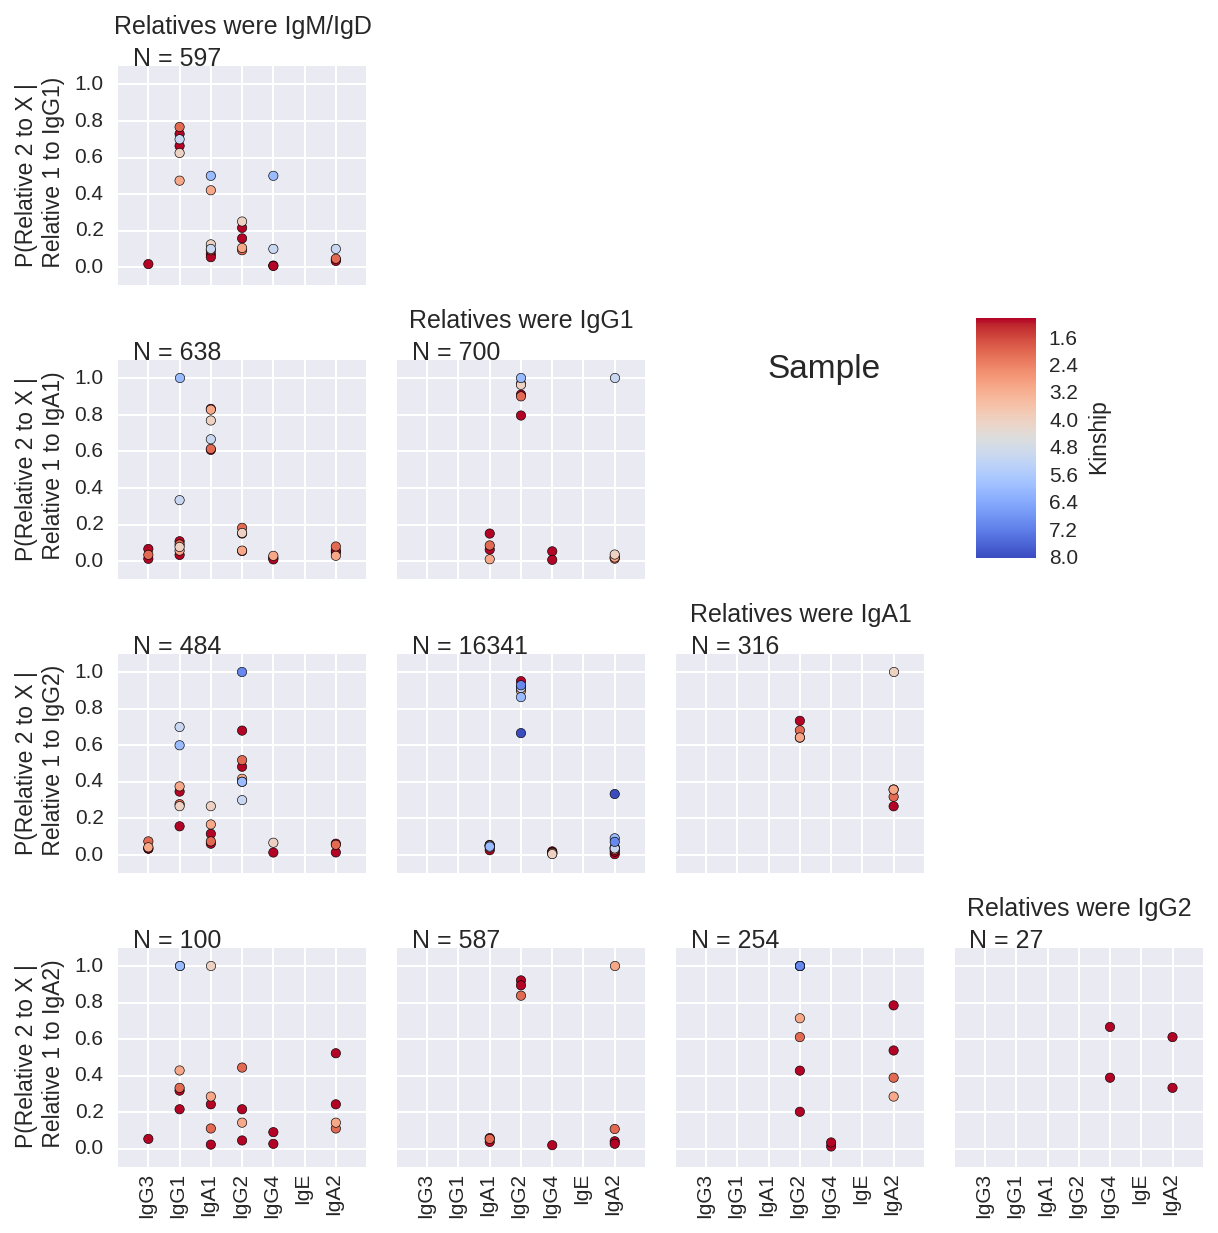

In [41]:
# Bin by kinship
fig, axes = plot_cond_probs_by_bins(df_V1, "kinship", 8)
axes[1,2].text(3, 1, "Sample", size=16)
# if savefig: save_figure(fig, "sib_conditional_probabilities_V1", output_dir, output_suffix, output_formats, savefig_args)

# Show concordance using Yule's Q

In [33]:
def yules_Q(a, b, c, d):
    OR = (float(a) * float(d)) / (float(b) * float(c))
    Q = (OR - 1) / (OR + 1)
    return Q

def calc_Q(df, bin_by):
    
    start_time = time.time()
    
    df_Q = pd.DataFrame(columns=["isotype", "destination_isotype", bin_by, "Q", "num_cases", "a", "b", "c", "d"])

    i = 0

    for isotype, group in df.groupby('mrca_isotype'):

        for myBin, group2 in group.groupby(bin_by):

            possible_switch_destinations = list(set(list(group2.sib1_switch_isotype.unique()) + list(group2.sib2_switch_isotype.unique())))
            
            for dest in possible_switch_destinations:

                num_cases = group2.shape[0]

                a = sum((group2.sib1_switch_isotype == dest) & (group2.sib2_switch_isotype == dest))
                b = sum((group2.sib1_switch_isotype == dest) & (group2.sib2_switch_isotype != dest))
                c = sum((group2.sib1_switch_isotype != dest) & (group2.sib2_switch_isotype == dest))
                d = sum((group2.sib1_switch_isotype != dest) & (group2.sib2_switch_isotype != dest))

                min_count_cutoff = 1
                if (a != 0 and b != 0 and c != 0 and d != 0) and (a >= min_count_cutoff and b >= min_count_cutoff and c >= min_count_cutoff and d >= min_count_cutoff):
                    Q = yules_Q(a, b, c, d)
                    df_Q.loc[i] = [isotype, dest, myBin, Q, num_cases, a, b, c, d]
                    i += 1
                else:
                    # Q is not defined
                    # print "Q not defined", kinship, isotype, dest, a, b, c, d
                    Q = np.nan
    
#    print "Elapsed time (wall clock):", time.time() - start_time
    return df_Q

def get_df_Qs(df):
    df_Q_kinship = calc_Q(df, bin_by="kinship")
    df_Q_max_sib_dist_bin = calc_Q(df, bin_by="max_sib_dist_bin")
    df_Q_mean_sib_dist_bin = calc_Q(df, bin_by="mean_sib_dist_bin")
    return df_Q_kinship, df_Q_max_sib_dist_bin, df_Q_mean_sib_dist_bin

In [34]:
# Calculate Q for datasets
dfs_Q_binned = []

for df in dfs:
    _, x, _ = get_df_Qs(df)
    dfs_Q_binned.append(x)
    
dfs_Q_binned_shuffled = []

for df in dfs_shuffled:
    _, x, _ = get_df_Qs(df)
    dfs_Q_binned_shuffled.append(x)
    
    
# _, df_Q_max_sib_dist_bin_V1, _ = get_df_Qs(df_V1)
# _, df_Q_max_sib_dist_bin_V3, _ = get_df_Qs(df_V3)

# _, df_Q_max_sib_dist_bin_V1_shuffled, _ = get_df_Qs(df_V1_shuffled)
# _, df_Q_max_sib_dist_bin_V3_shuffled, _ = get_df_Qs(df_V3_shuffled)

# Repeated shuffles to get confidence intervals on Q

In [44]:
N = 1000 # number of replicates (10 takes 5-10 seconds per df, 1000 takes 500-1000 secs per df)

In [45]:
def shuffles(df, N, bin_by):
    
    start_time = time.time()
    
    df_Q_shuffleds = []
    
    for _ in xrange(N):
        df_shuffled = shuffle(df)
        df_Q_shuffled = calc_Q(df_shuffled, bin_by)
        df_Q_shuffleds.append(df_Q_shuffled.copy(deep=True))
        
    print "Elapsed time (wall clock):", time.time() - start_time
    
    return df_Q_shuffleds

In [188]:
dfs_Q_binned_shuffleds = []

for df in dfs:
    dfs_Q_binned_shuffleds.append(shuffles(df, N, "max_sib_dist_bin"))

Elapsed time (wall clock): 502.688760042
Elapsed time (wall clock): 988.858648062
Elapsed time (wall clock): 923.11897397


# Plot Yule's Q against mutational distance

In [59]:
def plot_Q_by_bin_all(df_Q, df_Q_shuffleds, bin_by):
    
    isotypes_to_skip = ["IgG3", "IgG4", "IgE"]
    isotypes_to_skip_for_Q = isotypes_to_skip

    isotype_to_row_num = {"IgG1": 0, "IgA1": 1, "IgG2": 2, "IgA2": 3}
    isotype_to_col_num = {"Naive": 0, "IgG1": 1, "IgA1": 2, "IgG2": 3}

    fig, axes = plt.subplots(len(set(df_Q.destination_isotype.unique()) - set(isotypes_to_skip)), len(set(df_Q.isotype.unique()) - set(isotypes_to_skip_for_Q)), figsize=(8, 8), sharex=True, sharey=True)

    # Hide all axes by default
    for a1 in axes:
        for a2 in a1:
            a2.axis('off')

    for isotype, group in df_Q.groupby('isotype'):

        if isotype in isotypes_to_skip_for_Q: continue
        col = isotype_to_col_num[isotype]

        for destination_isotype, group2 in group.groupby('destination_isotype'):

            if destination_isotype in isotypes_to_skip: continue

            row = isotype_to_row_num[destination_isotype]
            ax = axes[row,col]

            # Plot
            x = group2[bin_by]
            y = group2.Q
            ax.plot(x, y, c='red', marker='o', linewidth=2)

            # Turn on axis
            ax.axis('on')

            # Titles
            if row == col:
                ax.set_title("Relatives were " + isotype.replace("Naive", "IgM/IgD"), y=1.1)
                
            # Switch to label
            switch_string = "Switch to " + destination_isotype
            ax.text(1, 1.05, switch_string, fontsize=12, zorder=10)
            
            # Plot shuffled traces
            for df_Q_shuff in df_Q_shuffleds:
                my_df_shuff = df_Q_shuff[(df_Q_shuff.isotype == isotype) & (df_Q_shuff.destination_isotype == destination_isotype)]
                x = my_df_shuff[bin_by]
                y = my_df_shuff.Q
                color = "#666666"
                ax.plot(x, y, c=color, alpha=0.2, linewidth=0.5, zorder=1)

    for row, ax_row in enumerate(axes):
        for col, ax in enumerate(ax_row):
            # ax.set_xlim([1, 10])
            ax.set_ylim([-1, 1])
            ax.tick_params(axis='x', which='both', top='off')
            ax.tick_params(axis='y', which='both', right='off')
            if col > 0: ax.tick_params(axis='y', which='both', left='off')
            if row != len(axes)-1: ax.tick_params(axis='x', which='both', bottom='off')

#     for ax in axes[-1]:
# #        ax.tick_params(axis='x', which='both', bottom='off', labelbottom='off')
#         ax.set_xlabel("Kinship level")

    for ax_row in axes:
        ax_row[0].set_ylabel("Yule's Q")

    plt.tight_layout(pad=0.1, h_pad=0.3)
    
    return fig, axes

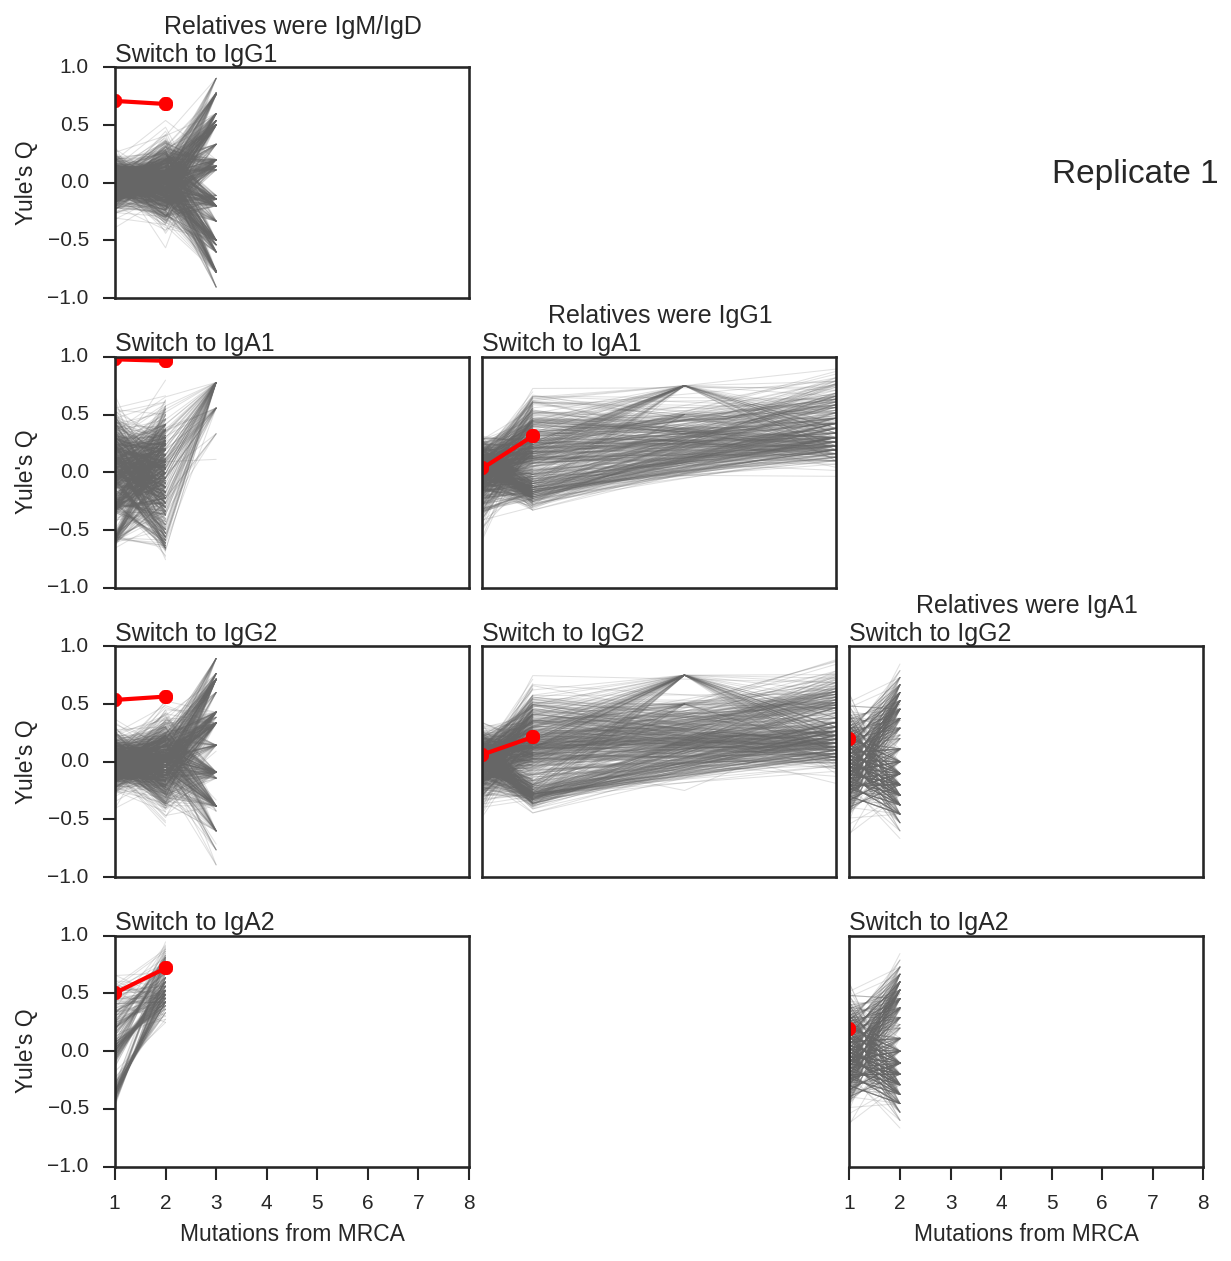

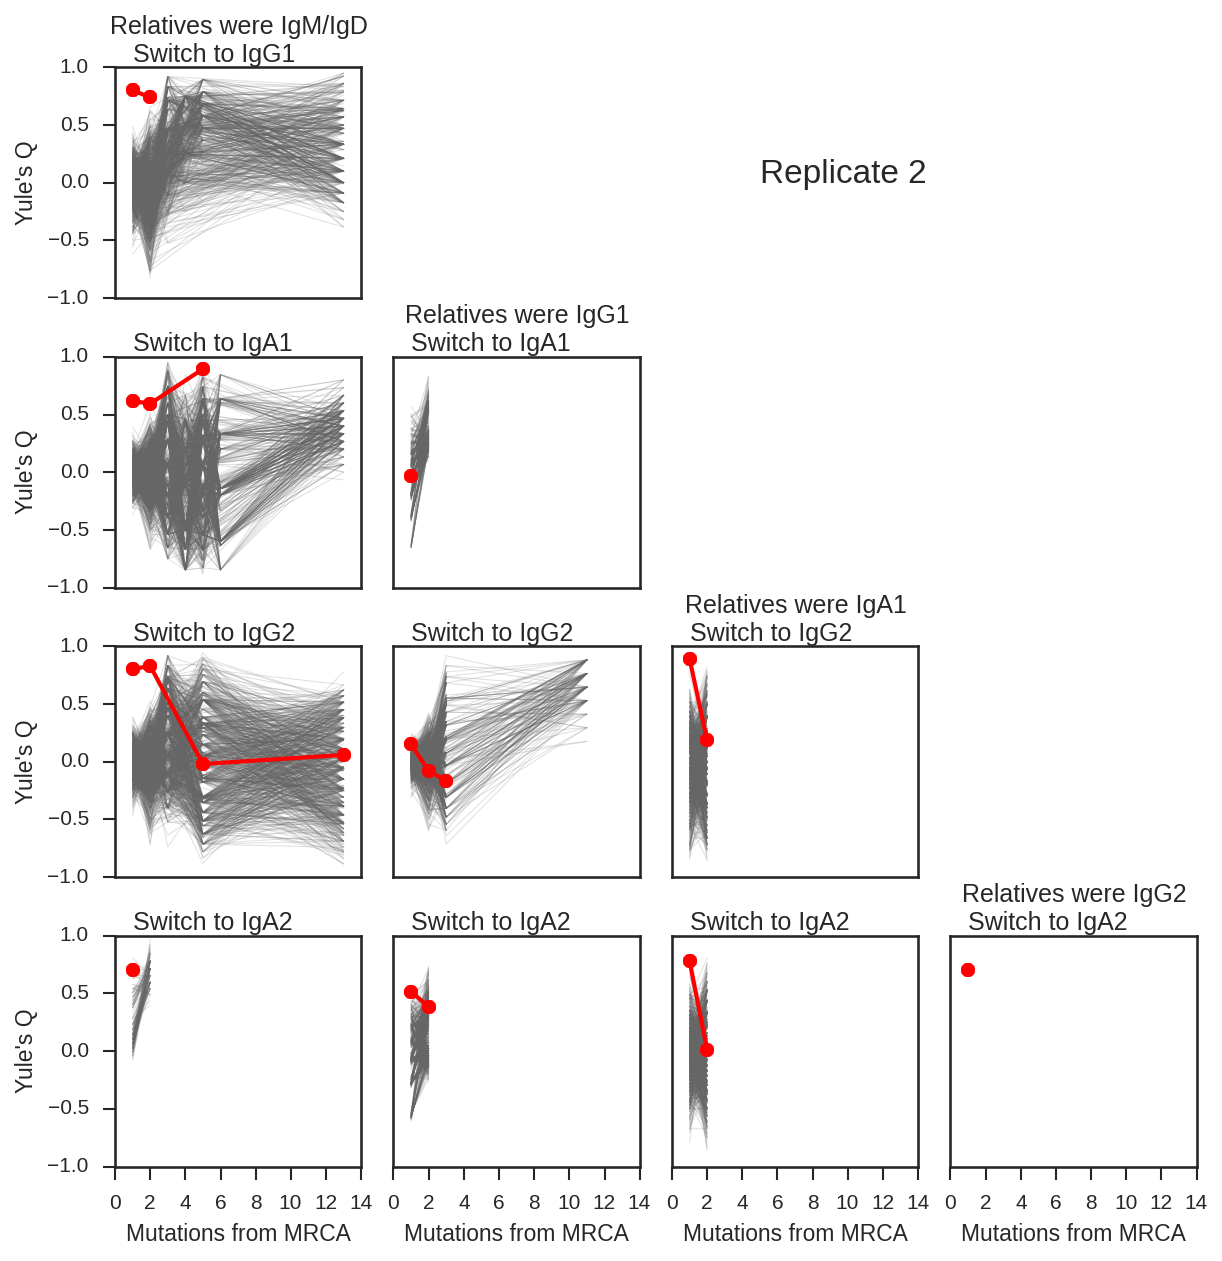

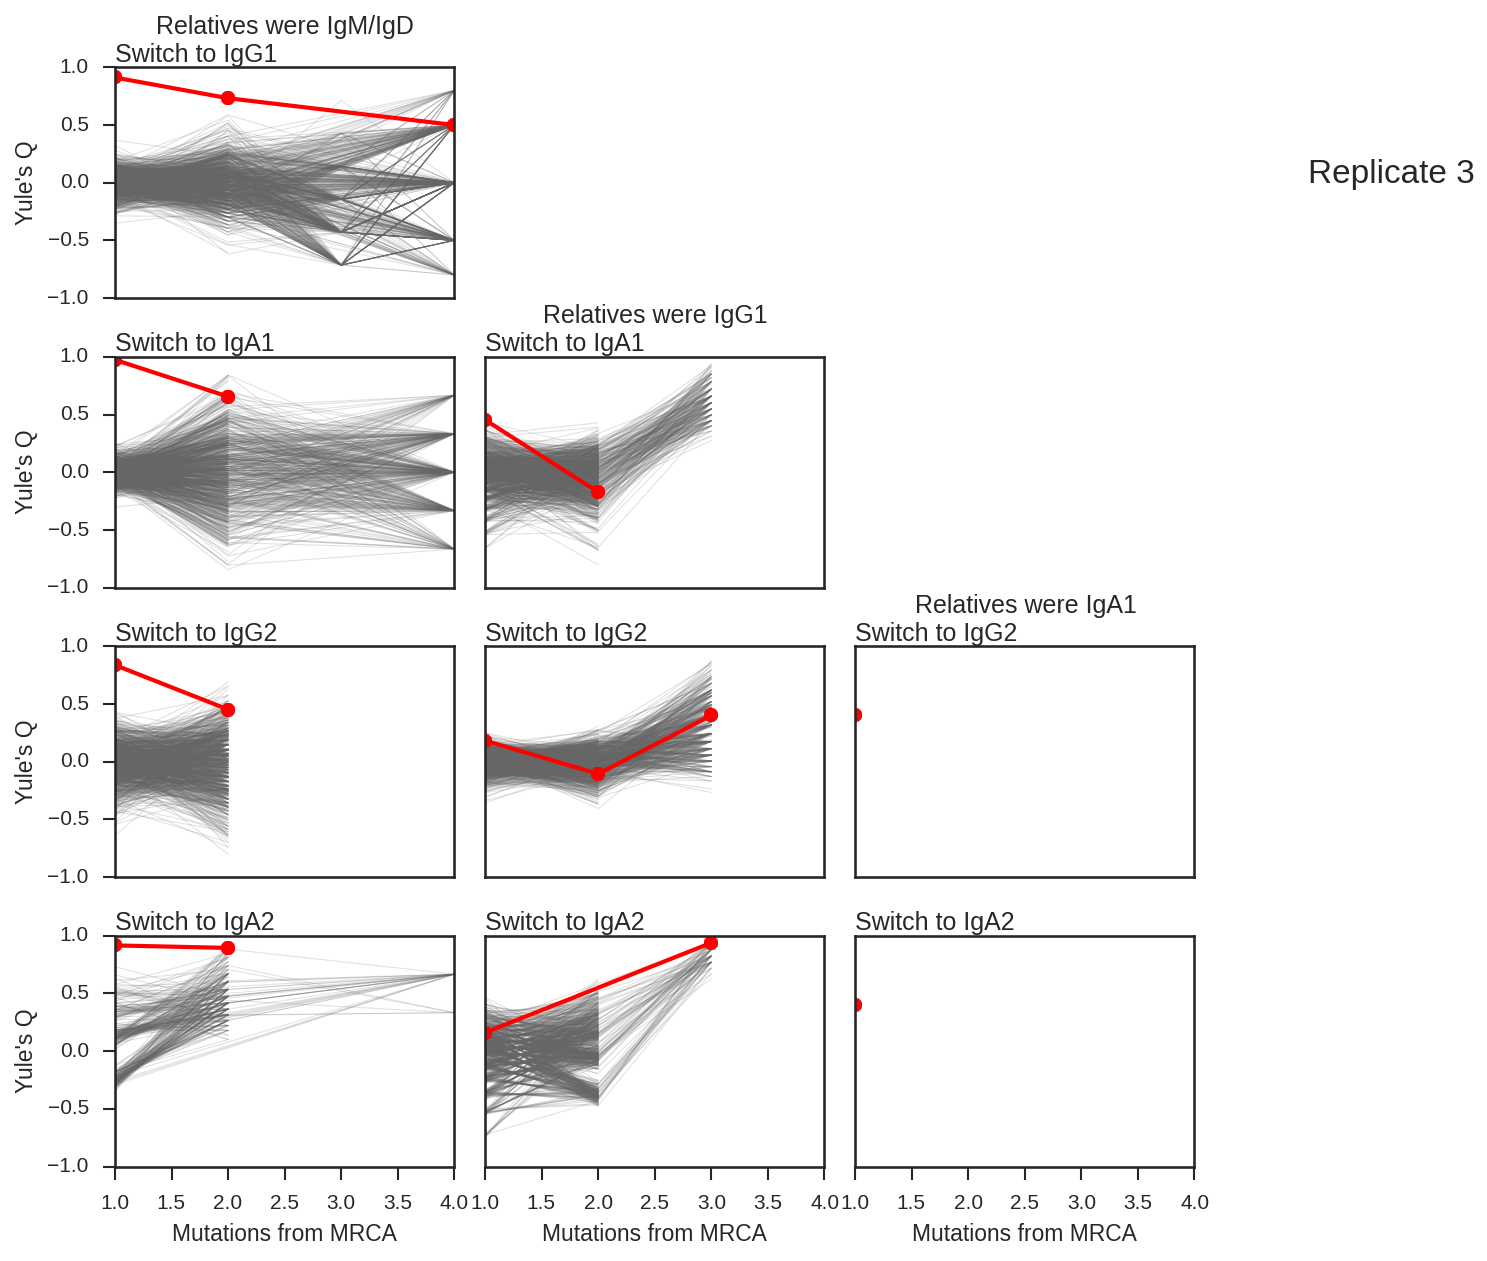

In [192]:
for i, name in enumerate(names):

    fig, axes = plot_Q_by_bin_all(dfs_Q_binned[i], dfs_Q_binned_shuffleds[i], bin_by="max_sib_dist_bin")
    
    for ax in axes[-1]:
        ax.set_xlabel("Mutations from MRCA")
        
    axes[0,2].text(5, 0, name, ha="left", size=16)
    
    # if savefig: save_figure(fig, "sib_culture_yules_Q_subplots_Replicate" + str(i), output_dir, output_suffix, output_formats, savefig_args)

In [130]:
# Plot for only Naive cells with pretty format

def plot_Q_by_bin_oneIsotype(df_Qs, df_Q_shuffledss, from_isotype, bin_by):
    
    to_isotypes = ["IgG1", "IgA1", "IgG2", "IgA2"]
    isotype_to_col_num = dict(zip(to_isotypes, range(len(to_isotypes))))
    
    sns.set_style("ticks")
    
    fig, axes = plt.subplots(3, 4, figsize=(8,6), sharex=True, sharey=True)
    
    for to_isotype in to_isotypes:
        
        col_num = isotype_to_col_num[to_isotype]
        
        rows = [0, 1, 2]
        for i in rows:
            
            ax = axes[i, col_num]
            df_Q = df_Qs[i]
            df_Q_shuffleds = df_Q_shuffledss[i]

            myData = df_Q[df_Q["isotype"] == from_isotype][df_Q["destination_isotype"] == to_isotype]
            x = myData[bin_by]
            y = myData.Q
            ax.plot(x, y, c='red', marker='o', linewidth=1, label="Data")

            for df_Q_shuff in df_Q_shuffleds:
                my_df_shuff = df_Q_shuff[(df_Q_shuff.isotype == from_isotype) & (df_Q_shuff.destination_isotype == to_isotype)]
                x = my_df_shuff[bin_by]
                y = my_df_shuff.Q
                color = "#666666"
                ax.plot(x, y, c=color, alpha=0.2, linewidth=0.5, zorder=1, label="")
                
            ax.plot([], [], c=color, alpha=0.2, linewidth=0.5, label="Shuffled")
    
    for i, ax_row in enumerate(axes):
        for ax in ax_row:
            sns.despine()
            xticks = ax.get_xticks()
            ax.set_xlim(xticks[0]-0.1,xticks[-1]+0.1)
            ax.set_xticks(xticks)
            yticks = ax.get_yticks()
            ax.set_ylim(yticks[0]-0.1,yticks[-1]+0.1)
            ax.set_yticks(yticks)
            ax.set_xticklabels([0, 10, 20, 30, 40, 50])
    
    for ax, to_isotype in zip(axes[0], to_isotypes):
        ax.set_title(from_isotype + " -> " + to_isotype)
    
    fig.text(0.5, -0.02, "Mutations from MRCA", ha='center', size=12)
    fig.text(-0.015, 0.5, "Yule's Q", va='center', rotation='vertical', size=12)

    axes[-1, -1].legend(bbox_to_anchor = (1.15, 0.4, 1, 1), prop={'size':12})
    
    plt.tight_layout()
    
    return fig, axes

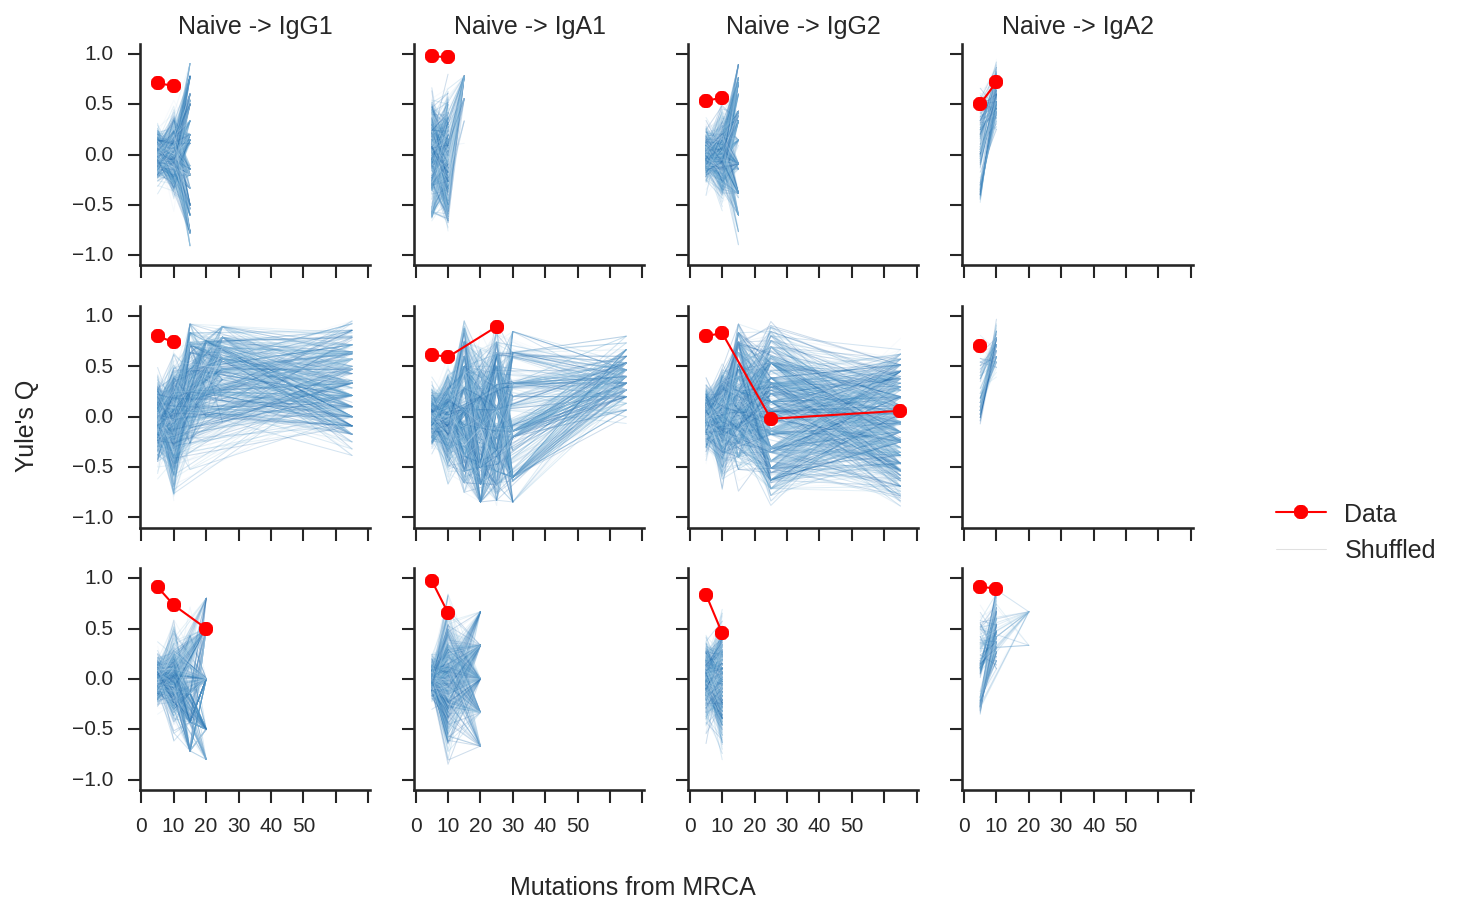

In [191]:
fig, axes = plot_Q_by_bin_oneIsotype(dfs_Q_binned, dfs_Q_binned_shuffleds,
                                     from_isotype="Naive", bin_by="max_sib_dist_bin")

# fig.text(0.98, 0.76, "Sample", va='center', rotation=270, size=12)
# fig.text(0.98, 0.31, "Bio. Rep.", va='center', rotation=270, size=12)

# if savefig: save_figure(fig, "yulesQ_vs_max_sib_dist_bin_Naive", output_dir, output_suffix, output_formats, savefig_args)

In [ ]:
# Plot one panel

def plot_Q_by_bin_oneIsotype_onePanel(df_Q, df_Q_shuffleds, from_isotype, to_isotype, bin_by):
    
    sns.set_style("ticks")

    fig, ax = plt.subplots(1, 1, figsize=(3,3))

    myData = df_Q[df_Q["isotype"] == from_isotype][df_Q["destination_isotype"] == to_isotype]
    x = myData[bin_by]
    y = myData.Q
    ax.plot(x, y, c='red', marker='o', linewidth=1, label="Data")

    for df_Q_shuff in df_Q_shuffleds:
        my_df_shuff = df_Q_shuff[(df_Q_shuff.isotype == from_isotype) & (df_Q_shuff.destination_isotype == to_isotype)]
        x = my_df_shuff[bin_by]
        y = my_df_shuff.Q
        color = "#666666"
        ax.plot(x, y, c=color, alpha=0.2, linewidth=0.5, zorder=1, label="")

    ax.plot([], [], c=color, alpha=0.2, linewidth=0.5, label="Shuffled")

    sns.despine()
    xticks = ax.get_xticks()
    ax.set_xlim(xticks[0]-0.1,xticks[-1]+0.1)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels([0, 10, 20, 30])
    yticks = ax.get_yticks()
    ax.set_ylim(yticks[0]-0.1,yticks[-1]+0.1)
    ax.set_yticks(yticks)
#    ax.set_aspect('equal')
    
    ax.set_title(from_isotype.replace("Naive", "IgM/IgD") + " -> " + to_isotype)
    ax.set_xlabel("Mutations from MRCA")
    ax.set_ylabel("Yule's Q")
    
#     fig.text(0.5, -0.02, "Mutations from MRCA", ha='center', size=12)
#     fig.text(-0.015, 0.5, "Yule's Q", va='center', rotation='vertical', size=12)

    ax.legend(bbox_to_anchor = (0.73, -0.3, 1, 1), prop={'size':12})
    
    plt.tight_layout()
    
    return fig, axes

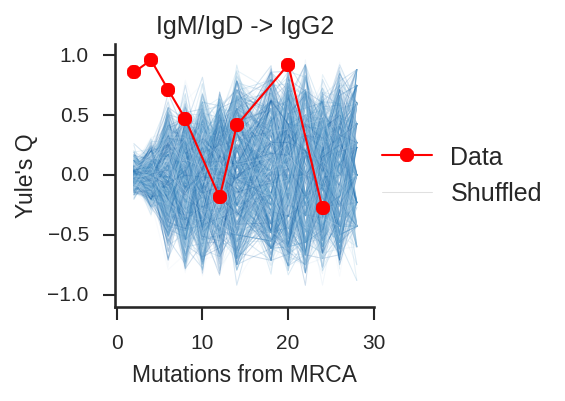

In [183]:
fig, ax = plot_Q_by_bin_oneIsotype_onePanel(df_Q_max_sib_dist_bin_V1, df_Q_max_sib_dist_bin_V1_shuffleds, "Naive", "IgG2", "max_sib_dist_bin")
if savefig: save_figure(fig, "yulesQ_vs_max_sib_dist_bin_Naive_IgG2", output_dir, output_suffix, output_formats, savefig_args)

In [177]:
df_Q_max_sib_dist_bin_V1[df_Q_max_sib_dist_bin_V1["isotype"] == "Naive"][df_Q_max_sib_dist_bin_V1["destination_isotype"] == "IgG2"]

isotype destination_isotype  max_sib_dist_bin         Q  num_cases    a  \
4    Naive                IgG2                 1  0.859051        969  504   
7    Naive                IgG2                 2  0.961706        364  192   
9    Naive                IgG2                 3  0.714286         89   54   
11   Naive                IgG2                 4  0.469880         81   61   
12   Naive                IgG2                 6 -0.187817         64   40   
13   Naive                IgG2                 7  0.416667         26   17   
14   Naive                IgG2                10  0.924051         27   19   
16   Naive                IgG2                12 -0.280000         36   18   

      b   c    d visit  
4   104  97  264    V1  
7    28  17  127    V1  
9    13   9   13    V1  
11    6  11    3    V1  
12    9  13    2    V1  
13    1   7    1    V1  
14    1   3    4    V1  
16    8   8    2    V1

# Plot Yule's Q for most closely related cells (by mutational distance)

In [38]:
for df, name in zip(dfs_Q_binned, names):
    df["experiment_name"] = name
    
df_Q_combined = pd.concat(dfs_Q_binned)

In [39]:
def plot_Q_top_bin(df_Q, bin_by):
    
    # Filter for top bin and sufficiently large sample
    df = df_Q.loc[df_Q[bin_by] == 1]
    df = df.loc[df['num_cases'] >= 100]
    
    # Sort
    df["isotype"] = pd.Categorical(df["isotype"], isotype_names)
    df["destination_isotype"] = pd.Categorical(df["destination_isotype"], isotype_names)
    df["experiment_name"] = pd.Categorical(df["experiment_name"], names)
    df.sort(["isotype", "destination_isotype", "experiment_name"], inplace=True)
    
    # Plot
    sns.set_style("ticks")
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))

    x = []
    y = []
    visits = []
    labels = []
    
    visit_to_color = {"Replicate 1": "#8da0cb", "Replicate 2": "#fc8d62", "Replicate 3": "#66c2a5"}
    
    for i, (_, row) in enumerate(df.iterrows()):
        
        x.append(i)
        y.append(float(row.Q))
        
        visits.append(row.experiment_name)
        print row.experiment_name
        
        label = row.isotype + " -> " + row.destination_isotype
        labels.append(label)
    
    colors = [visit_to_color[v] for v in visits]
    ax.scatter(x, y, c=colors)

    ax.set_xlim(min(x)-1, max(x)+1)
    ax.set_ylim(-1.05, 1.05)

    ax.set_ylabel("Yule's Q")

    ax.xaxis.tick_top()
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    
    sns.despine()
    plt.tight_layout()
    
    return fig, ax

Replicate 1
Replicate 2
Replicate 1
Replicate 2
Replicate 3
Replicate 1
Replicate 2
Replicate 3
Replicate 1
Replicate 2
Replicate 3
Replicate 2
Replicate 1
Replicate 2
Replicate 3
Replicate 2
Replicate 2
Replicate 2
Replicate 1
Replicate 2
Replicate 3
Replicate 1
Replicate 2
Replicate 3
Replicate 2
Replicate 2
Replicate 3
Replicate 3
Replicate 3


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


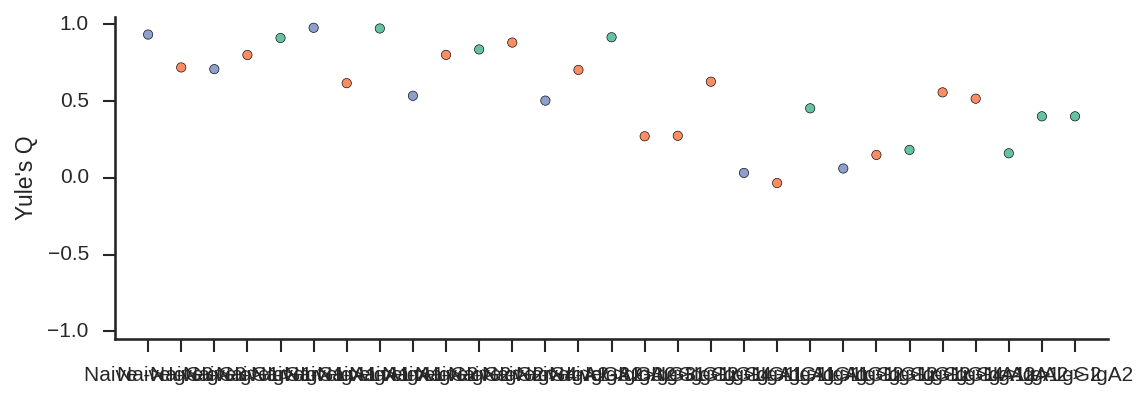

In [145]:
fig, ax = plot_Q_top_bin(df_Q_combined, bin_by="max_sib_dist_bin")

## Add shuffled data as error bars

In [40]:
# df_Q_shuffleds = {"V1": df_Q_max_sib_dist_bin_V1_shuffleds, "V3": df_Q_max_sib_dist_bin_V3_shuffleds}
# df_Q_shuffleds = {"V1": df_Q_max_sib_dist_bin_V1_shuffleds}

df_Q_shuffleds_combined = dict(zip(names, dfs_Q_binned_shuffleds))

In [41]:
def plot_Q_top_bin_with_shuffles(df_Q, df_Q_shuffleds, bin_by):
    
    # Filter for top bin and sufficiently large sample
    df = df_Q.loc[df_Q[bin_by] == 1]
    df = df.loc[df['num_cases'] >= 100]
    
    # Sort
    df["isotype"] = pd.Categorical(df["isotype"], isotype_names)
    df["destination_isotype"] = pd.Categorical(df["destination_isotype"], isotype_names)
    df["experiment_name"] = pd.Categorical(df["experiment_name"], names)
    df.sort(["isotype", "destination_isotype", "experiment_name"], inplace=True)
    
    isotypes_to_skip = ["IgG3", "IgG4", "IgE"]
    
    # Plot
    sns.set_style("ticks")
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))

    X = []
    Y = []
    visits = []
    labels = []
    
    isotypes = []
    destination_isotypes = []
    
    visit_to_color = {"Replicate 1": "w", "Replicate 2": "#bdbdbd", "Replicate 3": "k"}
    
    i = 0
    prev_isotype = ""
    prev_destination_isotype = ""
    
    for _, row in df.iterrows():
        
        if row.isotype in isotypes_to_skip or row.destination_isotype in isotypes_to_skip: continue
        if row.isotype != "Naive": continue
        if row.destination_isotype == "IgA2": continue

        if row.isotype != prev_isotype or row.destination_isotype != prev_destination_isotype:
            i += 3
            prev_isotype = row.isotype
            prev_destination_isotype = row.destination_isotype
        else:
            i += 1
        
        X.append(i)
        Y.append(float(row.Q))
        
        visits.append(row.experiment_name)
        
        label = row.isotype + " -> " + row.destination_isotype
        label = label.replace("Naive", "IgM/IgD")
        labels.append(label)
        
        isotypes.append(row.isotype)
        destination_isotypes.append(row.destination_isotype)
        
    colors = [visit_to_color[v] for v in visits]
    ax.scatter(X, Y, c=colors, s=30, zorder=10)
    
    bounds = True
    if bounds:
        # Plot bounds from shuffled data
        for x, v, isotype, destination_isotype in zip(X, visits, isotypes, destination_isotypes):

            if row.isotype in isotypes_to_skip or row.destination_isotype in isotypes_to_skip: continue

            shuffleds = df_Q_shuffleds[v]
            Qs = []

            for i in range(len(shuffleds)):
                df = shuffleds[i]
                a = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].a
                Q = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].Q
    #             if len(a) > 0:
    #                 if int(a) > 1 and len(Q) > 0:
    #                     Qs.append(float(Q))
                if len(Q) > 0: Qs.append(float(Q))

            if len(Qs) > 0:
                mean = np.mean(Qs)
                std = np.std(Qs)
                lower = mean - std
                upper = mean + std
                ax.errorbar([x], [mean], yerr=[[mean-lower],[upper-mean]], c="k", linewidth=1, capthick=1, zorder=1)
                print x, v, isotype, destination_isotype, len(Qs)
            else:
                print "x, v, isotype, destination_isotype"
                print x, v, isotype, destination_isotype
                print "has len(Q) == 0 for shuffled sets"
                print

    ax.set_xlim(min(X)-1, max(X)+1)
    ax.set_ylim(-1.05, 1.05)

    ax.set_ylabel("Yule's Q")
    
    ax.xaxis.tick_top()

    # All ticks
    # ax.set_xticks(X)
    # ax.set_xticklabels(labels, rotation=45, ha="right")
    
    # Nonredundant ticks
    num_visits = len(df_Q["experiment_name"].unique())
    if num_visits == 2:
        xtick_offset = 0.5
    else:
        xtick_offset = 0
    X_nonredundant = list(np.array(X[0::num_visits]) + xtick_offset + 1)
    labels_nonredundant = labels[0::num_visits]
    ax.set_xticks(X_nonredundant)
    ax.set_xticklabels(labels_nonredundant, rotation=45, ha="left")

    ax.yaxis.set_ticks_position('left')
    
    plt.tight_layout()
    
    return fig, ax

3 Replicate 1 Naive IgG1 1000
4 Replicate 2 Naive IgG1 1000
5 Replicate 3 Naive IgG1 1000
8 Replicate 1 Naive IgA1 974
9 Replicate 2 Naive IgA1 1000
10 Replicate 3 Naive IgA1 1000
13 Replicate 1 Naive IgG2 1000
14 Replicate 2 Naive IgG2 1000
15 Replicate 3 Naive IgG2 1000


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


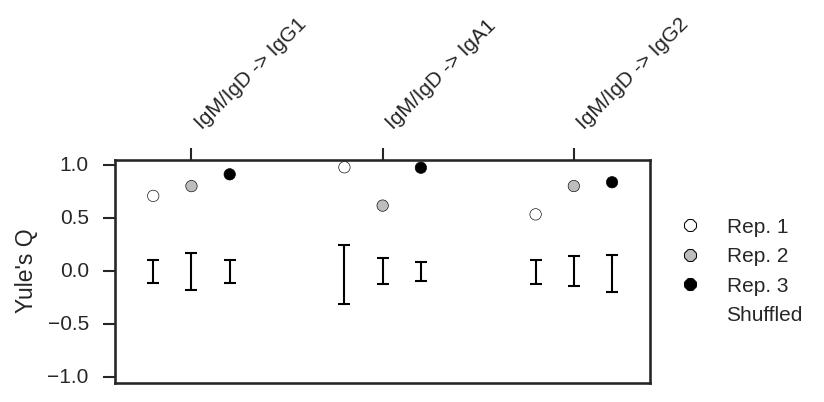

In [43]:
# All visits
fig, ax = plot_Q_top_bin_with_shuffles(df_Q_combined, df_Q_shuffleds_combined, bin_by="max_sib_dist_bin")

ax.plot(-1, -1, linestyle="none", marker="o", color="#ffffff", markeredgewidth=0.5, markersize=6, label="Rep. 1")
ax.plot(-1, -1, linestyle="none", marker="o", color="#bdbdbd", markeredgewidth=0.5, markersize=6, label="Rep. 2")
ax.plot(-1, -1, linestyle="none", marker="o", color="#000000", markeredgewidth=0.5, markersize=6, label="Rep. 3")
ax.plot(-1, -1, linestyle="none", marker="None", color="#000000", markeredgewidth=0.5, markersize=6, label="Shuffled")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

if savefig: save_figure(fig, "yulesQ_topBin_culture160105", output_dir, output_suffix, output_formats, savefig_args)

# Examine shuffled Qs to see if they are Gaussian

In [58]:
# Define model function to be used to fit to the data
def gaussian(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

In [59]:
def plot_Q_hist(df_shuffleds, isotype, destination_isotype, bin_by):

    # Get values of Q
    Qs = []
    for i in range(len(df_shuffleds)):
        df = df_shuffleds[i]
        Q = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].Q
        if len(Q) > 0: Qs.append(float(Q))

    print "Number of Q:", len(Qs)

    # Fit histogram with Gaussian
    hist, bin_edges = np.histogram(Qs, bins=30, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    coeff, var_matrix = scipy.optimize.curve_fit(gaussian, bin_centers, hist, p0=p0)
    hist_fit = gaussian(bin_centers, *coeff)

    # Plot histogram and Gaussian fit
    sns.set_style("ticks")
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    
    width = 0.7 * (bin_centers[1] - bin_centers[0])
    
    ax.bar(bin_centers, hist, align="center", width=width, label='Data')
    ax.plot(bin_centers, hist_fit, c="red", label='Fit')
    
    ax.set_xlim(min(bin_centers)-0.1, max(bin_centers)+0.1)
    
    ax.set_xlabel("Q")
    ax.set_ylabel("Count")
    
    ax.set_title(isotype.replace("Naive", "IgM/IgD") + " -> " + destination_isotype)
    
    ax.legend(loc="upper right")
    
    sns.despine()
    plt.tight_layout()
    
    return fig, ax, Qs

Number of Q: 1000


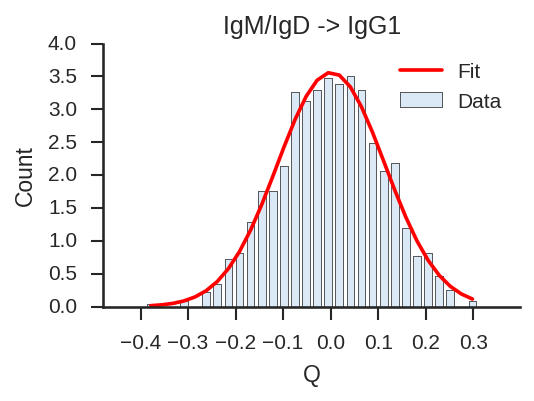

In [61]:
fig, ax, Qs = plot_Q_hist(df_Q_shuffleds_combined["Replicate 1"], "Naive", "IgG1", bin_by="max_sib_dist_bin")

Number of Q: 974


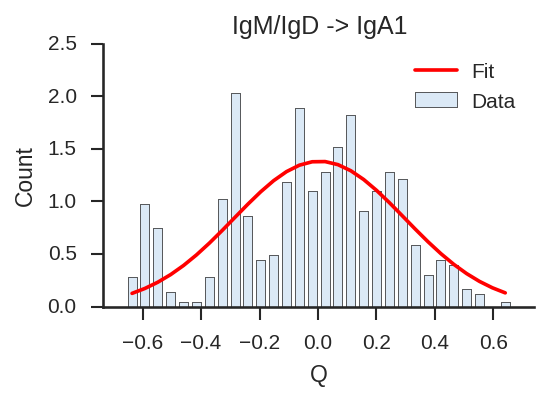

In [62]:
fig, ax, Qs = plot_Q_hist(df_Q_shuffleds_combined["Replicate 1"], "Naive", "IgA1", bin_by="max_sib_dist_bin")

Number of Q: 1000


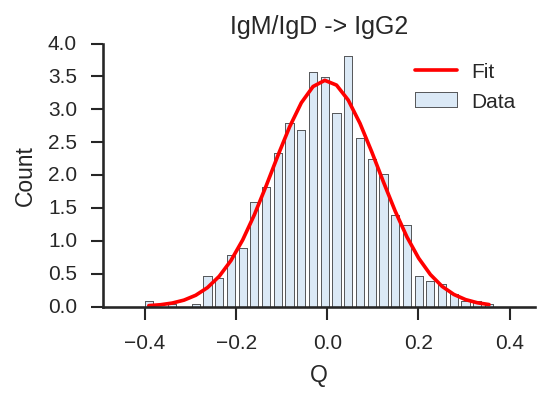

In [63]:
fig, ax, Qs = plot_Q_hist(df_Q_shuffleds_combined["Replicate 1"], "Naive", "IgG2", bin_by="max_sib_dist_bin")

Yes, these are Gaussian! We can fit Gaussians and compute an exact P value. Examples of fit Gaussians are overlaid in red.

# Calculate exact P values for observed Q by fitting Gaussians

In [69]:
def calc_Pvalues_Q_with_shuffles(df_Q, df_Q_shuffleds, bin_by):
    
    # Filter for top bin and sufficiently large sample
    df = df_Q.loc[df_Q[bin_by] == 1]
    df = df.loc[df['num_cases'] >= 100]
    
    # Sort
    df["isotype"] = pd.Categorical(df["isotype"], isotype_names)
    df["destination_isotype"] = pd.Categorical(df["destination_isotype"], isotype_names)
    df["experiment_name"] = pd.Categorical(df["experiment_name"], names)
    df.sort(["isotype", "destination_isotype", "experiment_name"], inplace=True)
    
    # Load values of Q
    X = []
    Y = []
    visits = []
    labels = []
    
    isotypes = []
    destination_isotypes = []
        
    isotypes_to_skip = ["IgG3", "IgG4", "IgE"]
    
#    visit_to_day = {"V1": "Sample", "V2": "D7", "V3": "Bio. Rep."}

    for i, (_, row) in enumerate(df.iterrows()):
    
        if row.isotype in isotypes_to_skip or row.destination_isotype in isotypes_to_skip: continue
        
        X.append(i)
        Y.append(float(row.Q))
        
        visits.append(row.experiment_name)
        
        label = row.isotype + " -> " + row.destination_isotype
        labels.append(label)
        
        isotypes.append(row.isotype)
        destination_isotypes.append(row.destination_isotype)
    
    # Load shuffled data, fit Gaussian, plot shuffled data, fit, and observed value, compute exact P value
    for x, y, v, isotype, destination_isotype in zip(X, Y, visits, isotypes, destination_isotypes):
        
        shuffleds = df_Q_shuffleds[v]
        Qs = []
        
        for i in range(len(shuffleds)):
            df = shuffleds[i]
            Q = df[df[bin_by] == 1][df["isotype"] == isotype][df["destination_isotype"] == destination_isotype].Q
            if len(Q) > 0: Qs.append(float(Q))

        # Fit histogram with Gaussian
        hist, bin_edges = np.histogram(Qs, bins=20, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

        coeff, var_matrix = scipy.optimize.curve_fit(gaussian, bin_centers, hist, p0=p0)
        hist_fit = gaussian(bin_centers, *coeff)

        # Compute P value of observed x
        A, mu, sigma = coeff
        P = scipy.stats.norm(loc=mu, scale=np.absolute(sigma)).sf(y)
        
        print isotype, destination_isotype, v, "Q = %.2f" % y, "mu = %.2e" % mu, "sigma = %.2e" % sigma, "P = %.2e" % P
        
        # Plot histogram and Gaussian fit
        sns.set_style("ticks")

        fig, ax = plt.subplots(1, 1, figsize=(4,3))

        width = 0.7 * (bin_centers[1] - bin_centers[0])

        ax.bar(bin_centers, hist, align="center", width=width, label='Shuffles')
        ax.plot(bin_centers, hist_fit, c="red", label='Fit')
        ax.scatter(y, 0.1, marker="o", c="k", label='Observed', s=10, zorder=10)
        
        ax.set_ylim(bottom=0)

        ax.set_xlabel("Q")
        ax.set_ylabel("Density")
        title = isotype.replace("Naive", "IgM/IgD") + " -> " + destination_isotype + ", " + v + ", P = %.2e" % P
        ax.set_title(title)
        ax.legend(loc="upper right")

        sns.despine()
        plt.tight_layout()
        
    return fig, ax

Naive IgG1 Replicate 1 Q = 0.71 mu = 1.36e-03 sigma = 1.14e-01 P = 2.42e-10
Naive IgG1 Replicate 2 Q = 0.80 mu = 1.36e-02 sigma = 1.75e-01 P = 3.45e-06
Naive IgG1 Replicate 3 Q = 0.91 mu = 4.23e-04 sigma = -1.07e-01 P = 9.03e-18
Naive IgA1 Replicate 1 Q = 0.98 mu = 6.73e-03 sigma = 2.93e-01 P = 4.53e-04
Naive IgA1 Replicate 2 Q = 0.62 mu = 6.09e-03 sigma = -1.16e-01 P = 6.53e-08
Naive IgA1 Replicate 3 Q = 0.97 mu = -3.85e-03 sigma = -8.96e-02 P = 4.72e-28
Naive IgG2 Replicate 1 Q = 0.54 mu = -3.49e-03 sigma = -1.15e-01 P = 1.36e-06
Naive IgG2 Replicate 2 Q = 0.80 mu = 7.19e-03 sigma = -1.45e-01 P = 2.37e-08
Naive IgG2 Replicate 3 Q = 0.84 mu = -8.90e-03 sigma = 1.77e-01 P = 8.71e-07
Naive IgA2 Replicate 1 Q = 0.50 mu = -5.59e-02 sigma = 4.94e-01 P = 1.29e-01
Naive IgA2 Replicate 2 Q = 0.70 mu = 1.23e-01 sigma = 2.66e-01 P = 1.44e-02


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

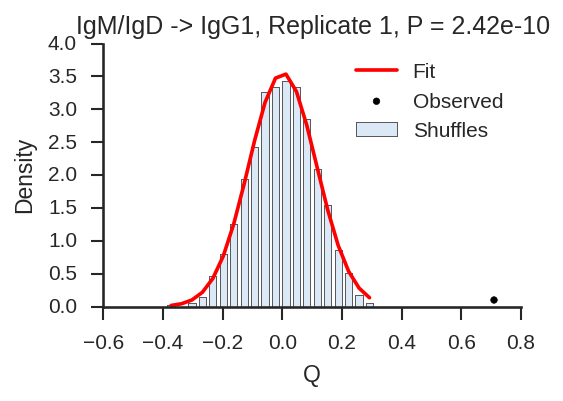

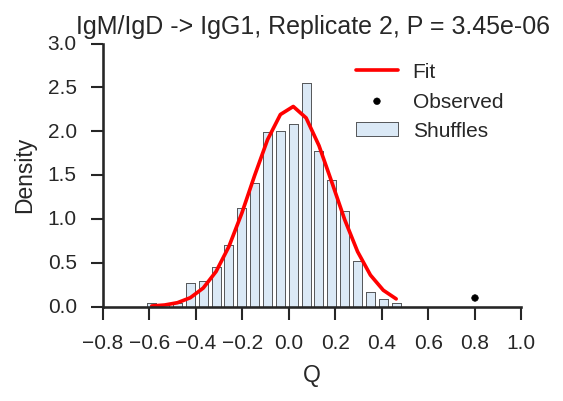

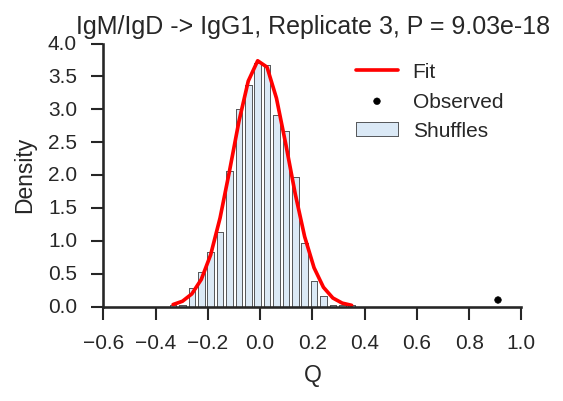

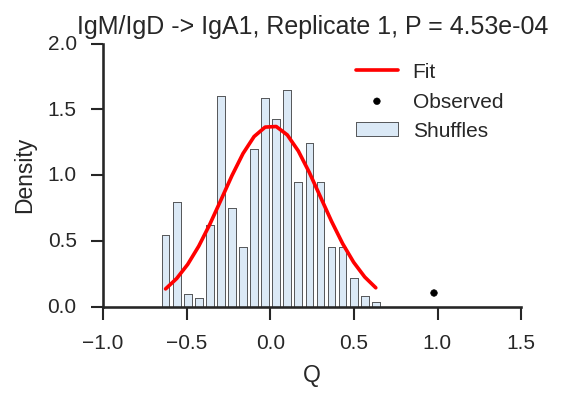

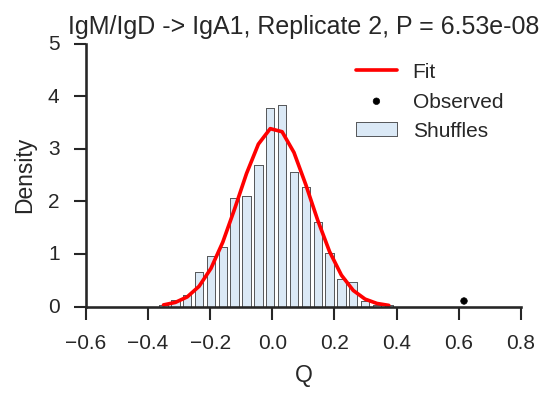

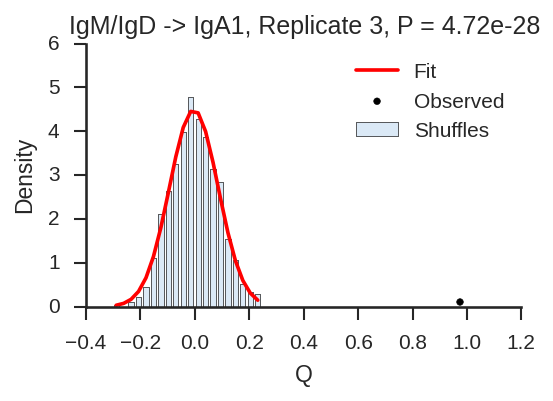

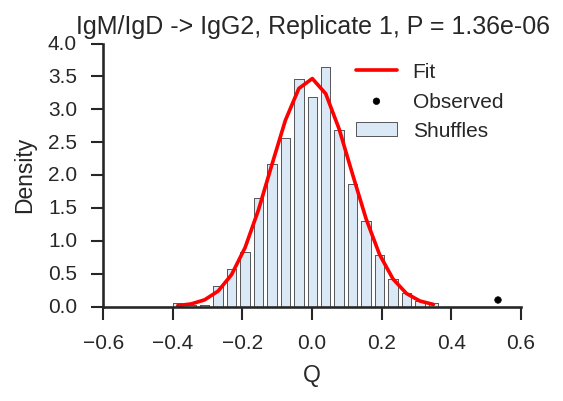

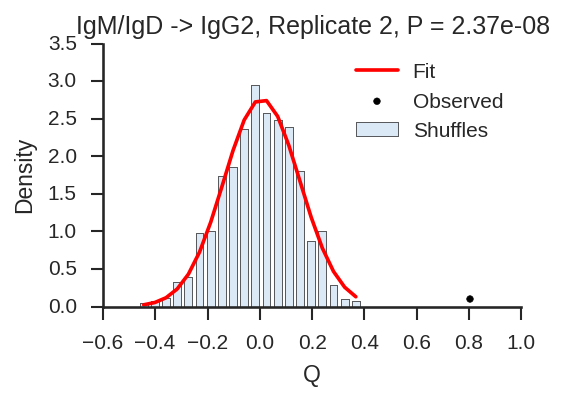

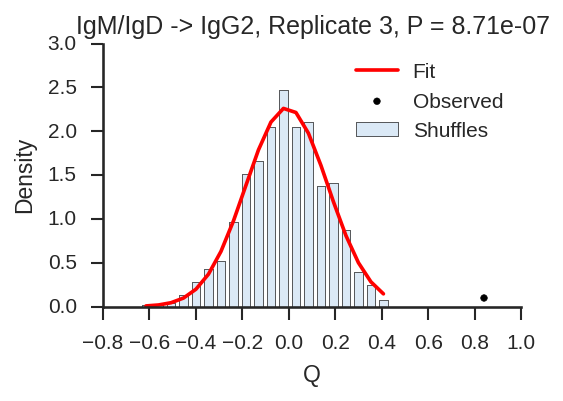

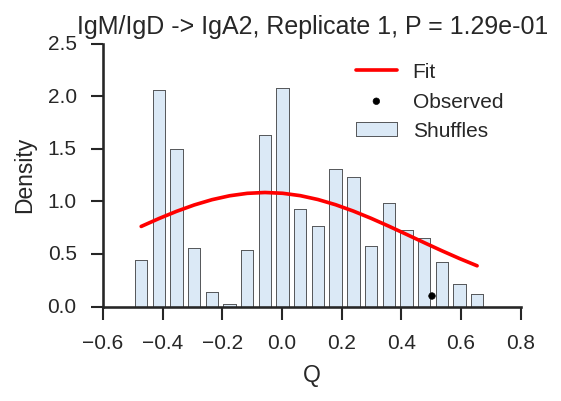

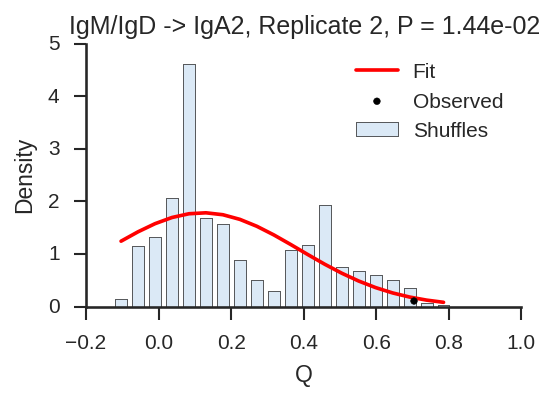

In [71]:
calc_Pvalues_Q_with_shuffles(df_Q_combined, df_Q_shuffleds_combined, bin_by="max_sib_dist_bin")

Naive IgG1 V1 Q = 0.98 mu = -8.05e-02 sigma = -4.99e-01 P = 1.66e-02
Naive IgA1 V1 Q = 0.87 mu = -2.06e-03 sigma = 7.43e-02 P = 2.37e-32
Naive IgG2 V1 Q = 0.86 mu = -2.11e-03 sigma = -6.76e-02 P = 1.85e-37


/local10G/rfhorns/resources/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(<matplotlib.figure.Figure at 0x7f45e796d350>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4605787810>)

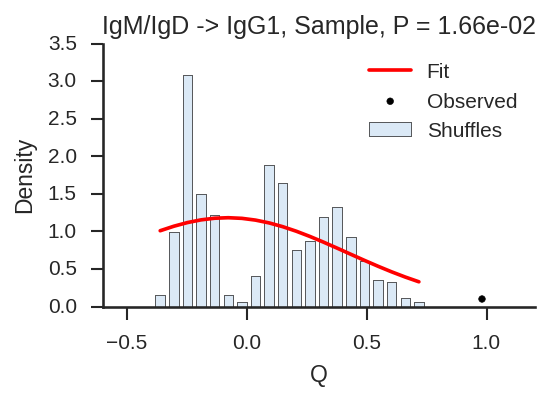

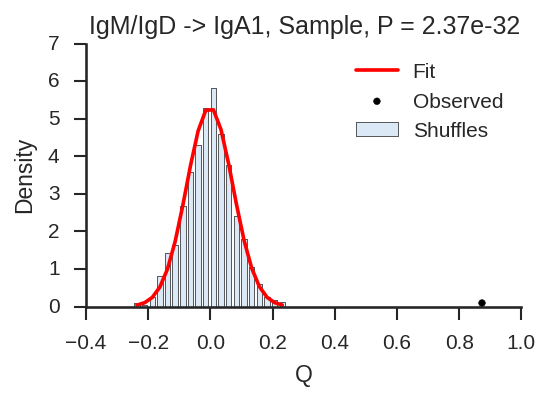

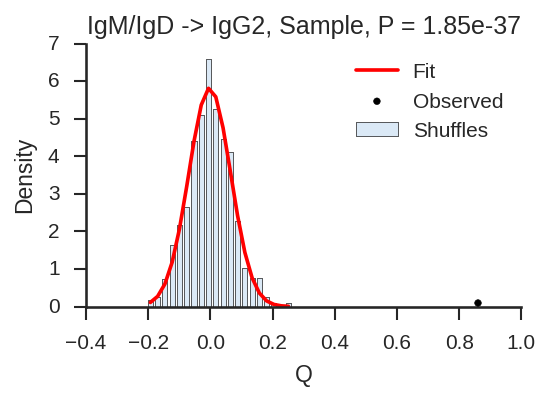

In [174]:
calc_Pvalues_Q_with_shuffles(df_Q, df_Q_shuffleds, bin_by="max_sib_dist_bin")

In [ ]:
# Do mutations before switch correlate between two relatives? No.
plt.scatter(df_V1.sib1_switch_dist, df_V1.sib2_switch_dist)
plt.scatter(df_V3.sib1_switch_dist, df_V3.sib2_switch_dist)